# Text Generation using Transformer for Sherlock Holmes (Step-by-step, comparable to GRU)


In [1]:
import os
from collections import Counter
import re
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import tensorflow as tf
import matplotlib.pyplot as plt
import platform
print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

# Weights & Biases (toggle)
USE_WANDB = True  # set False to disable
if USE_WANDB:
    import wandb
    from wandb.integration.keras import WandbMetricsLogger
    # If you want online logging, ensure WANDB_API_KEY is set in your environment
    # For offline logging: export WANDB_MODE=offline
    wandb.login()
    wandb.init(project='nlp-arch-compare', group='transformer')


Python version: 3.13.0
Tensorflow version: 2.20.0
Keras version: 3.11.3


wandb: Currently logged in as: sofiesch (sofiesch-kth-royal-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: setting up run u7tmag3u


wandb: Tracking run with wandb version 0.22.1


wandb: Run data is saved locally in /Users/sofieschnitzer/Desktop/KTH_HT25_filer/II2202/NLP-architecture-comparison/wandb/run-20251006_231350-u7tmag3u
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run dashing-darkness-10


wandb: ⭐️ View project at https://wandb.ai/sofiesch-kth-royal-institute-of-technology/nlp-arch-compare


wandb: 🚀 View run at https://wandb.ai/sofiesch-kth-royal-institute-of-technology/nlp-arch-compare/runs/u7tmag3u


In [2]:
# Dataset path (same as GRU)
cache_dir = './tmp-transformer'
dataset_file_name = 'sherlockholmes.txt'
dataset_file_path = dataset_file_name
print('Using dataset file:', dataset_file_path)

# Load data
text = open(dataset_file_path, mode='r').read()
print(text[:250])


Using dataset file: sherlockholmes.txt
The Adventures of Sherlock Holmes

by Arthur Conan Doyle

I. A SCANDAL IN BOHEMIA


I.

To Sherlock Holmes she is always _the_ woman. I have seldom heard him
mention her under any other name. In his eyes she eclipses and
predominates the whole of her


In [3]:
# Tokenizer and data pipeline (mirrors GRU)
from tokenizers import ByteLevelBPETokenizer
from transformers import GPT2Tokenizer

save_dir = "./tokenizer"
# Train tokenizer if folder is empty
if (not os.path.exists(save_dir)) or (len(os.listdir(save_dir)) == 0):
    tokenizer = ByteLevelBPETokenizer()
    tokenizer.train(files=[dataset_file_path], vocab_size=30_000, min_frequency=2)
    os.makedirs(save_dir, exist_ok=True)
    tokenizer.save_model(save_dir)

custom_tokenizer = GPT2Tokenizer.from_pretrained(save_dir)

# Tokenize full text
input_ids = custom_tokenizer.encode(text)
print(f"Total tokens in text: {len(input_ids)}")

# Build tf.data pipeline
import tensorflow as tf

tokens_dataset = tf.data.Dataset.from_tensor_slices(input_ids)
sequence_length = 100
examples_per_epoch = len(input_ids) // (sequence_length + 1)
print(f'Examples per epoch: {examples_per_epoch}')

sequences = tokens_dataset.batch(sequence_length + 1, drop_remainder=True)

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

BATCH_SIZE = 64
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print('Batched dataset size:', len(list(dataset.as_numpy_iterator())))


Total tokens in text: 144597
Examples per epoch: 1431


Batched dataset size: 22


2025-10-06 23:13:52.905039: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
# Show some examples of input-target pairs (like GRU)
# Use the unbatched (sequence_length) view to avoid confusion with batch dimension
preview_ds = sequences.map(split_input_target)
for input_example, target_example in preview_ds.take(1):
    for i in range(5):
        input_token = int(input_example[i].numpy())
        target_token = int(target_example[i].numpy())
        print(f'Step {i:2d}')
        print(f'  input token: {input_token} ({custom_tokenizer.decode([input_token])})')
        print(f'  expected output token: {target_token} ({custom_tokenizer.decode([target_token])})')


Step  0
  input token: 364 (The)
  expected output token: 407 ( A)
Step  1
  input token: 407 ( A)
  expected output token: 67 (d)
Step  2
  input token: 67 (d)
  expected output token: 2428 (venture)
Step  3
  input token: 2428 (venture)
  expected output token: 82 (s)
Step  4
  input token: 82 (s)
  expected output token: 283 ( of)


2025-10-06 23:13:52.921417: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# Transformer model (dynamic positional encoding)
import tensorflow as tf

EMBED_DIM = 256
MODEL_DIM = 256
NUM_HEADS = 8
FF_DIM = 1024
NUM_LAYERS = 4
DROPOUT = 0.1


def positional_encoding_dynamic(seq_len: tf.Tensor, depth: int) -> tf.Tensor:
    pos = tf.cast(tf.range(seq_len)[:, tf.newaxis], tf.float32)
    idx = tf.cast(tf.range(depth)[tf.newaxis, :], tf.float32)
    angle_rates = 1.0 / tf.pow(10000.0, (2 * (idx // 2)) / tf.cast(depth, tf.float32))
    angles = pos * angle_rates
    sines = tf.math.sin(angles[:, 0::2])
    cosines = tf.math.cos(angles[:, 1::2])
    pos_encoding = tf.concat([sines, cosines], axis=-1)
    return pos_encoding[tf.newaxis, ...]


def transformer_block(x: tf.Tensor, model_dim: int, ff_dim: int, num_heads: int, dropout: float) -> tf.Tensor:
    attn_out = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=model_dim, dropout=dropout)(x, x)
    attn_out = tf.keras.layers.Dropout(dropout)(attn_out)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + attn_out)

    ff = tf.keras.Sequential([
        tf.keras.layers.Dense(ff_dim, activation="relu"),
        tf.keras.layers.Dense(model_dim),
    ])
    ff_out = ff(x)
    ff_out = tf.keras.layers.Dropout(dropout)(ff_out)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + ff_out)
    return x


def build_model(vocab_size, embed_dim, model_dim, num_heads, ff_dim, num_layers, dropout):
    inputs = tf.keras.layers.Input(shape=(None,), dtype=tf.int32)
    emb = tf.keras.layers.Embedding(vocab_size, embed_dim)(inputs)
    proj = tf.keras.layers.Dense(model_dim)(emb)

    def add_positional(x):
        seq_len = tf.shape(x)[1]
        pe = positional_encoding_dynamic(seq_len, model_dim)
        return x + pe

    x = tf.keras.layers.Lambda(add_positional)(proj)

    for _ in range(num_layers):
        x = transformer_block(x, model_dim, ff_dim, num_heads, dropout)

    logits = tf.keras.layers.Dense(vocab_size)(x)
    model = tf.keras.Model(inputs, logits, name="token_transformer")
    return model

vocab_size = custom_tokenizer.vocab_size + 1
model = build_model(vocab_size, EMBED_DIM, MODEL_DIM, NUM_HEADS, FF_DIM, NUM_LAYERS, DROPOUT)
model.summary()


Model: "token_transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 256) │  2,366,976 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None, 256) │     65,792 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, None, 256) │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 256) │  2,103,552 │ lambda[0][0],     │
│ (MultiHeadAttentio… │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, None, 256) │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 256) │          0 │ lambda[0][0],     │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None, 256) │        512 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, None, 256) │    525,568 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, None, 256) │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None, 256) │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 256) │        512 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 256) │  2,103,552 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, None, 256) │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 256) │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 256) │        512 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, None, 256) │    525,568 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, None, 256) │          0 │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, None, 256) │          0 │ layer_normalizat

 Total params: 15,329,566 (58.48 MB)

 Trainable params: 15,329,566 (58.48 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Compile + callbacks (checkpoints, ResourceMonitorCB, and optional W&B)

def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=loss)

# Checkpoints
checkpoint_dir = cache_dir + '/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}.weights.h5')
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_best_only=True,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    verbose=1
)

# Early stopping only (match GRU); W&B handles system metrics
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

# Build callbacks list with optional W&B logger
callbacks = [checkpoint_cb, early_stopping]
if 'USE_WANDB' in globals() and USE_WANDB:
    callbacks.append(WandbMetricsLogger())


Epoch 1/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:36 7s/step - loss: 9.1750

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:06 3s/step - loss: 9.1450

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:01 3s/step - loss: 9.1169

 4/22 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - loss: 9.0912 

 5/22 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - loss: 9.0674

 6/22 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - loss: 9.0456

 7/22 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - loss: 9.0256

 8/22 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - loss: 9.0071

 9/22 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - loss: 8.9900

10/22 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - loss: 8.9736

11/22 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - loss: 8.9584

12/22 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - loss: 8.9440

13/22 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - loss: 8.9303

14/22 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - loss: 8.9172

15/22 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - loss: 8.9047

16/22 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - loss: 8.8927

17/22 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - loss: 8.8810

18/22 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - loss: 8.8698

19/22 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - loss: 8.8589

20/22 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - loss: 8.8483 

21/22 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - loss: 8.8380

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 8.8280


Epoch 1: loss improved from None to 8.61740, saving model to ./tmp-transformer/checkpoints/model_epoch_01.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - loss: 8.6174


Epoch 2/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:24 4s/step - loss: 8.2647

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:41 5s/step - loss: 8.2548

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:24 4s/step - loss: 8.2445

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:19 4s/step - loss: 8.2360

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:13 4s/step - loss: 8.2283

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:08 4s/step - loss: 8.2213

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:05 4s/step - loss: 8.2144

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:02 4s/step - loss: 8.2080

 9/22 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - loss: 8.2017 

10/22 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - loss: 8.1951

11/22 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step - loss: 8.1885

12/22 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - loss: 8.1820

13/22 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - loss: 8.1756

14/22 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - loss: 8.1693

15/22 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - loss: 8.1629

16/22 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - loss: 8.1566

17/22 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - loss: 8.1503

18/22 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - loss: 8.1438

19/22 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - loss: 8.1374

20/22 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 8.1310

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 8.1246 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 8.1182


Epoch 2: loss improved from 8.61740 to 7.98409, saving model to ./tmp-transformer/checkpoints/model_epoch_02.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 116s 5s/step - loss: 7.9841


Epoch 3/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:52 5s/step - loss: 7.6942

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:39 5s/step - loss: 7.6876

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:33 5s/step - loss: 7.6812

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:31 5s/step - loss: 7.6745

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:27 5s/step - loss: 7.6684

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:21 5s/step - loss: 7.6623

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:25 6s/step - loss: 7.6561

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:20 6s/step - loss: 7.6501

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:15 6s/step - loss: 7.6440

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:09 6s/step - loss: 7.6380

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:08 6s/step - loss: 7.6321

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:02 6s/step - loss: 7.6262

13/22 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - loss: 7.6203 

14/22 ━━━━━━━━━━━━━━━━━━━━ 49s 6s/step - loss: 7.6143

15/22 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - loss: 7.6084

16/22 ━━━━━━━━━━━━━━━━━━━━ 35s 6s/step - loss: 7.6026

17/22 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step - loss: 7.5967

18/22 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step - loss: 7.5910

19/22 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - loss: 7.5854

20/22 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - loss: 7.5797

21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 7.5740 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 7.5684


Epoch 3: loss improved from 7.98409 to 7.44999, saving model to ./tmp-transformer/checkpoints/model_epoch_03.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 135s 6s/step - loss: 7.4500


Epoch 4/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - loss: 7.1992

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:08 6s/step - loss: 7.1901

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:54 6s/step - loss: 7.1863

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:57 7s/step - loss: 7.1834

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:46 6s/step - loss: 7.1799

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:42 6s/step - loss: 7.1764

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:33 6s/step - loss: 7.1722

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:26 6s/step - loss: 7.1676

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:18 6s/step - loss: 7.1633

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:11 6s/step - loss: 7.1590

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:04 6s/step - loss: 7.1548

12/22 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - loss: 7.1504 

13/22 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - loss: 7.1463

14/22 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - loss: 7.1423

15/22 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - loss: 7.1384

16/22 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - loss: 7.1344

17/22 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step - loss: 7.1306

18/22 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - loss: 7.1267

19/22 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - loss: 7.1226

20/22 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 7.1185

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step - loss: 7.1145 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 7.1104


Epoch 4: loss improved from 7.44999 to 7.02547, saving model to ./tmp-transformer/checkpoints/model_epoch_04.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 124s 5s/step - loss: 7.0255


Epoch 5/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:46 5s/step - loss: 6.8559

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:48 5s/step - loss: 6.8464

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:43 5s/step - loss: 6.8430

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:38 5s/step - loss: 6.8406

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:33 5s/step - loss: 6.8367

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:26 5s/step - loss: 6.8330

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:19 5s/step - loss: 6.8291

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:14 5s/step - loss: 6.8244

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:09 5s/step - loss: 6.8205

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:03 5s/step - loss: 6.8171

11/22 ━━━━━━━━━━━━━━━━━━━━ 59s 5s/step - loss: 6.8138 

12/22 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - loss: 6.8109

13/22 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - loss: 6.8082

14/22 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - loss: 6.8052

15/22 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - loss: 6.8025

16/22 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - loss: 6.7995

17/22 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - loss: 6.7967

18/22 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - loss: 6.7940

19/22 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - loss: 6.7912

20/22 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 6.7884

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 6.7856 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 6.7827


Epoch 5: loss improved from 7.02547 to 6.72310, saving model to ./tmp-transformer/checkpoints/model_epoch_05.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 118s 5s/step - loss: 6.7231


Epoch 6/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:37 5s/step - loss: 6.5917

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:43 5s/step - loss: 6.5947

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:38 5s/step - loss: 6.5939

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:33 5s/step - loss: 6.5916

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:27 5s/step - loss: 6.5903

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:22 5s/step - loss: 6.5890

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:16 5s/step - loss: 6.5884

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:10 5s/step - loss: 6.5870

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:04 5s/step - loss: 6.5853

10/22 ━━━━━━━━━━━━━━━━━━━━ 59s 5s/step - loss: 6.5834 

11/22 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - loss: 6.5821

12/22 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - loss: 6.5808

13/22 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - loss: 6.5793

14/22 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - loss: 6.5776

15/22 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - loss: 6.5761

16/22 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - loss: 6.5747

17/22 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - loss: 6.5734

18/22 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - loss: 6.5719

19/22 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - loss: 6.5704

20/22 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - loss: 6.5690 

21/22 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step - loss: 6.5676

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 6.5661


Epoch 6: loss improved from 6.72310 to 6.53477, saving model to ./tmp-transformer/checkpoints/model_epoch_06.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 108s 5s/step - loss: 6.5348


Epoch 7/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:43 5s/step - loss: 6.4343

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:33 5s/step - loss: 6.4416

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:34 5s/step - loss: 6.4511

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:29 5s/step - loss: 6.4538

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:26 5s/step - loss: 6.4533

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:19 5s/step - loss: 6.4519

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:14 5s/step - loss: 6.4506

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:09 5s/step - loss: 6.4495

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:06 5s/step - loss: 6.4484

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:01 5s/step - loss: 6.4477

11/22 ━━━━━━━━━━━━━━━━━━━━ 56s 5s/step - loss: 6.4469 

12/22 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step - loss: 6.4463

13/22 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - loss: 6.4459

14/22 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - loss: 6.4454

15/22 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - loss: 6.4454

16/22 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - loss: 6.4454

17/22 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - loss: 6.4451

18/22 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - loss: 6.4449

19/22 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - loss: 6.4445

20/22 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 6.4440

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 6.4434 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 6.4429


Epoch 7: loss improved from 6.53477 to 6.43256, saving model to ./tmp-transformer/checkpoints/model_epoch_07.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 111s 5s/step - loss: 6.4326


Epoch 8/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:45 5s/step - loss: 6.3749

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:38 5s/step - loss: 6.3798

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:38 5s/step - loss: 6.3796

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:33 5s/step - loss: 6.3801

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:26 5s/step - loss: 6.3813

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:20 5s/step - loss: 6.3821

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:15 5s/step - loss: 6.3825

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:10 5s/step - loss: 6.3826

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:04 5s/step - loss: 6.3823

10/22 ━━━━━━━━━━━━━━━━━━━━ 59s 5s/step - loss: 6.3820 

11/22 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - loss: 6.3820

12/22 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - loss: 6.3820

13/22 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - loss: 6.3821

14/22 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - loss: 6.3826

15/22 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - loss: 6.3829

16/22 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - loss: 6.3832

17/22 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - loss: 6.3833

18/22 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - loss: 6.3834

19/22 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - loss: 6.3834

20/22 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - loss: 6.3833 

21/22 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step - loss: 6.3834

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 6.3836


Epoch 8: loss improved from 6.43256 to 6.38672, saving model to ./tmp-transformer/checkpoints/model_epoch_08.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step - loss: 6.3867


Epoch 9/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:54 5s/step - loss: 6.3606

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:04 6s/step - loss: 6.3659

 3/22 ━━━━━━━━━━━━━━━━━━━━ 2:18 7s/step - loss: 6.3663

 4/22 ━━━━━━━━━━━━━━━━━━━━ 2:11 7s/step - loss: 6.3659

 5/22 ━━━━━━━━━━━━━━━━━━━━ 2:06 7s/step - loss: 6.3640

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:56 7s/step - loss: 6.3637

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:46 7s/step - loss: 6.3640

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:36 7s/step - loss: 6.3633

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:27 7s/step - loss: 6.3624

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:20 7s/step - loss: 6.3614

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:13 7s/step - loss: 6.3607

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:06 7s/step - loss: 6.3601

13/22 ━━━━━━━━━━━━━━━━━━━━ 59s 7s/step - loss: 6.3594 

14/22 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - loss: 6.3591

15/22 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - loss: 6.3591

16/22 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - loss: 6.3594

17/22 ━━━━━━━━━━━━━━━━━━━━ 31s 6s/step - loss: 6.3594

18/22 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - loss: 6.3594

19/22 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - loss: 6.3592

20/22 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - loss: 6.3590

21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 6.3588 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 6.3587


Epoch 9: loss improved from 6.38672 to 6.35597, saving model to ./tmp-transformer/checkpoints/model_epoch_09.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 134s 6s/step - loss: 6.3560


Epoch 10/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:57 6s/step - loss: 6.3750

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:54 6s/step - loss: 6.3576

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:47 6s/step - loss: 6.3502

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:45 6s/step - loss: 6.3437

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:41 6s/step - loss: 6.3399

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:33 6s/step - loss: 6.3371

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:24 6s/step - loss: 6.3367

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:17 6s/step - loss: 6.3366

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:10 5s/step - loss: 6.3360

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:05 5s/step - loss: 6.3348

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:00 6s/step - loss: 6.3337

12/22 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - loss: 6.3322 

13/22 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step - loss: 6.3309

14/22 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step - loss: 6.3299

15/22 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - loss: 6.3290

16/22 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - loss: 6.3281

17/22 ━━━━━━━━━━━━━━━━━━━━ 31s 6s/step - loss: 6.3272

18/22 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - loss: 6.3263

19/22 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - loss: 6.3254

20/22 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - loss: 6.3246

21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 6.3237 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 6.3228


Epoch 10: loss improved from 6.35597 to 6.30441, saving model to ./tmp-transformer/checkpoints/model_epoch_10.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 135s 6s/step - loss: 6.3044


Epoch 11/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:48 5s/step - loss: 6.2287

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:29 7s/step - loss: 6.2344

 3/22 ━━━━━━━━━━━━━━━━━━━━ 2:06 7s/step - loss: 6.2395

 4/22 ━━━━━━━━━━━━━━━━━━━━ 2:02 7s/step - loss: 6.2438

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:55 7s/step - loss: 6.2480

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:45 7s/step - loss: 6.2502

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:38 7s/step - loss: 6.2525

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:29 6s/step - loss: 6.2540

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:23 6s/step - loss: 6.2553

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:16 6s/step - loss: 6.2560

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:09 6s/step - loss: 6.2565

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:03 6s/step - loss: 6.2566

13/22 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - loss: 6.2565 

14/22 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step - loss: 6.2563

15/22 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - loss: 6.2557

16/22 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - loss: 6.2552

17/22 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step - loss: 6.2549

18/22 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step - loss: 6.2547

19/22 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - loss: 6.2544

20/22 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - loss: 6.2541

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step - loss: 6.2537 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 6.2535


Epoch 11: loss improved from 6.30441 to 6.24821, saving model to ./tmp-transformer/checkpoints/model_epoch_11.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 130s 6s/step - loss: 6.2482


Epoch 12/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:59 6s/step - loss: 6.1917

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:37 5s/step - loss: 6.1845

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:34 5s/step - loss: 6.1837

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:29 5s/step - loss: 6.1847

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:24 5s/step - loss: 6.1842

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:19 5s/step - loss: 6.1851

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:14 5s/step - loss: 6.1856

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:08 5s/step - loss: 6.1858

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:03 5s/step - loss: 6.1853

10/22 ━━━━━━━━━━━━━━━━━━━━ 59s 5s/step - loss: 6.1850 

11/22 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - loss: 6.1846

12/22 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - loss: 6.1847

13/22 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - loss: 6.1852

14/22 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - loss: 6.1855

15/22 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - loss: 6.1857

16/22 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - loss: 6.1857

17/22 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - loss: 6.1859

18/22 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - loss: 6.1858

19/22 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - loss: 6.1859

20/22 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - loss: 6.1860 

21/22 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step - loss: 6.1859

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 6.1860


Epoch 12: loss improved from 6.24821 to 6.18753, saving model to ./tmp-transformer/checkpoints/model_epoch_12.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step - loss: 6.1875


Epoch 13/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:45 5s/step - loss: 6.1724

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:40 5s/step - loss: 6.1726

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:37 5s/step - loss: 6.1703

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:28 5s/step - loss: 6.1689

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:22 5s/step - loss: 6.1667

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:17 5s/step - loss: 6.1631

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:12 5s/step - loss: 6.1588

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:08 5s/step - loss: 6.1556

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:03 5s/step - loss: 6.1541

10/22 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - loss: 6.1522 

11/22 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - loss: 6.1505

12/22 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - loss: 6.1489

13/22 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - loss: 6.1474

14/22 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - loss: 6.1461

15/22 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - loss: 6.1450

16/22 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - loss: 6.1441

17/22 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - loss: 6.1430

18/22 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - loss: 6.1417

19/22 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - loss: 6.1403

20/22 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - loss: 6.1391 

21/22 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step - loss: 6.1381

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 6.1371


Epoch 13: loss improved from 6.18753 to 6.11673, saving model to ./tmp-transformer/checkpoints/model_epoch_13.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 107s 5s/step - loss: 6.1167


Epoch 14/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:38 5s/step - loss: 6.0529

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:41 5s/step - loss: 6.0415

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:31 5s/step - loss: 6.0458

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:27 5s/step - loss: 6.0478

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:21 5s/step - loss: 6.0457

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:17 5s/step - loss: 6.0435

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:15 5s/step - loss: 6.0428

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:11 5s/step - loss: 6.0410

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:06 5s/step - loss: 6.0400

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:01 5s/step - loss: 6.0385

11/22 ━━━━━━━━━━━━━━━━━━━━ 56s 5s/step - loss: 6.0380 

12/22 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step - loss: 6.0372

13/22 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - loss: 6.0369

14/22 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - loss: 6.0367

15/22 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - loss: 6.0367

16/22 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - loss: 6.0367

17/22 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - loss: 6.0368

18/22 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - loss: 6.0369

19/22 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - loss: 6.0368

20/22 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 6.0366

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 6.0366 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 6.0366


Epoch 14: loss improved from 6.11673 to 6.03655, saving model to ./tmp-transformer/checkpoints/model_epoch_14.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 111s 5s/step - loss: 6.0366


Epoch 15/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:48 5s/step - loss: 5.9900

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:40 5s/step - loss: 5.9936

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:31 5s/step - loss: 5.9833

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:29 5s/step - loss: 5.9794

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:23 5s/step - loss: 5.9772

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:19 5s/step - loss: 5.9750

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:14 5s/step - loss: 5.9731

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:09 5s/step - loss: 5.9720

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:04 5s/step - loss: 5.9708

10/22 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - loss: 5.9698 

11/22 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - loss: 5.9692

12/22 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - loss: 5.9684

13/22 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - loss: 5.9681

14/22 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - loss: 5.9677

15/22 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - loss: 5.9673

16/22 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - loss: 5.9669

17/22 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - loss: 5.9662

18/22 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - loss: 5.9656

19/22 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - loss: 5.9650

20/22 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - loss: 5.9644 

21/22 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step - loss: 5.9639

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 5.9634


Epoch 15: loss improved from 6.03655 to 5.95340, saving model to ./tmp-transformer/checkpoints/model_epoch_15.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 110s 5s/step - loss: 5.9534


Epoch 16/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:49 5s/step - loss: 5.9361

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:00 6s/step - loss: 5.9264

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:51 6s/step - loss: 5.9190

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:46 6s/step - loss: 5.9148

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:38 6s/step - loss: 5.9083

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:33 6s/step - loss: 5.9039

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:28 6s/step - loss: 5.9018

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:25 6s/step - loss: 5.9005

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:21 6s/step - loss: 5.8990

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:15 6s/step - loss: 5.8980

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:09 6s/step - loss: 5.8976

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:02 6s/step - loss: 5.8970

13/22 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step - loss: 5.8966 

14/22 ━━━━━━━━━━━━━━━━━━━━ 48s 6s/step - loss: 5.8959

15/22 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - loss: 5.8951

16/22 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - loss: 5.8939

17/22 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step - loss: 5.8928

18/22 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step - loss: 5.8921

19/22 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - loss: 5.8913

20/22 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - loss: 5.8904

21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 5.8896 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 5.8886


Epoch 16: loss improved from 5.95340 to 5.86958, saving model to ./tmp-transformer/checkpoints/model_epoch_16.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 132s 6s/step - loss: 5.8696


Epoch 17/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:01 6s/step - loss: 5.8380

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:50 6s/step - loss: 5.8114

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:42 5s/step - loss: 5.7991

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:35 5s/step - loss: 5.7922

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:29 5s/step - loss: 5.7913

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:26 5s/step - loss: 5.7914

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:26 6s/step - loss: 5.7921

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:23 6s/step - loss: 5.7925

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:18 6s/step - loss: 5.7925

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:16 6s/step - loss: 5.7920

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:08 6s/step - loss: 5.7918

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:02 6s/step - loss: 5.7917

13/22 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - loss: 5.7917 

14/22 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step - loss: 5.7917

15/22 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - loss: 5.7918

16/22 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - loss: 5.7920

17/22 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step - loss: 5.7920

18/22 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step - loss: 5.7921

19/22 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - loss: 5.7920

20/22 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - loss: 5.7919

21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 5.7917 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 5.7915


Epoch 17: loss improved from 5.86958 to 5.78631, saving model to ./tmp-transformer/checkpoints/model_epoch_17.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 133s 6s/step - loss: 5.7863


Epoch 18/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:53 5s/step - loss: 5.6531

 2/22 ━━━━━━━━━━━━━━━━━━━━ 3:12 10s/step - loss: 5.6657

 3/22 ━━━━━━━━━━━━━━━━━━━━ 2:46 9s/step - loss: 5.6832 

 4/22 ━━━━━━━━━━━━━━━━━━━━ 2:28 8s/step - loss: 5.6930

 5/22 ━━━━━━━━━━━━━━━━━━━━ 2:12 8s/step - loss: 5.6988

 6/22 ━━━━━━━━━━━━━━━━━━━━ 2:00 8s/step - loss: 5.7036

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:47 7s/step - loss: 5.7052

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:38 7s/step - loss: 5.7064

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:28 7s/step - loss: 5.7063

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:20 7s/step - loss: 5.7069

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:13 7s/step - loss: 5.7076

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:06 7s/step - loss: 5.7083

13/22 ━━━━━━━━━━━━━━━━━━━━ 58s 7s/step - loss: 5.7089 

14/22 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - loss: 5.7096

15/22 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - loss: 5.7105

16/22 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - loss: 5.7109

17/22 ━━━━━━━━━━━━━━━━━━━━ 31s 6s/step - loss: 5.7111

18/22 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - loss: 5.7113

19/22 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - loss: 5.7116

20/22 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - loss: 5.7118

21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 5.7119 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 5.7119


Epoch 18: loss improved from 5.78631 to 5.71190, saving model to ./tmp-transformer/checkpoints/model_epoch_18.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 133s 6s/step - loss: 5.7119


Epoch 19/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:50 5s/step - loss: 5.5719

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:53 6s/step - loss: 5.5930

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:43 5s/step - loss: 5.6051

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:36 5s/step - loss: 5.6073

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:31 5s/step - loss: 5.6106

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:26 5s/step - loss: 5.6132

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:20 5s/step - loss: 5.6152

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:17 6s/step - loss: 5.6163

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:15 6s/step - loss: 5.6174

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:09 6s/step - loss: 5.6184

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:03 6s/step - loss: 5.6200

12/22 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - loss: 5.6212 

13/22 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - loss: 5.6221

14/22 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - loss: 5.6230

15/22 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - loss: 5.6239

16/22 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step - loss: 5.6248

17/22 ━━━━━━━━━━━━━━━━━━━━ 28s 6s/step - loss: 5.6255

18/22 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - loss: 5.6260

19/22 ━━━━━━━━━━━━━━━━━━━━ 16s 6s/step - loss: 5.6265

20/22 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - loss: 5.6270

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step - loss: 5.6275 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 5.6280


Epoch 19: loss improved from 5.71190 to 5.63829, saving model to ./tmp-transformer/checkpoints/model_epoch_19.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 122s 6s/step - loss: 5.6383


Epoch 20/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:46 5s/step - loss: 5.6690

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:58 6s/step - loss: 5.6514

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:59 6s/step - loss: 5.6465

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:49 6s/step - loss: 5.6426

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:41 6s/step - loss: 5.6373

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:30 6s/step - loss: 5.6359

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:23 6s/step - loss: 5.6346

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:17 6s/step - loss: 5.6326

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:11 6s/step - loss: 5.6293

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:06 6s/step - loss: 5.6265

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:00 5s/step - loss: 5.6243

12/22 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - loss: 5.6222 

13/22 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - loss: 5.6201

14/22 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - loss: 5.6183

15/22 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - loss: 5.6162

16/22 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - loss: 5.6144

17/22 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - loss: 5.6124

18/22 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - loss: 5.6105

19/22 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - loss: 5.6088

20/22 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 5.6070

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 5.6052 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 5.6037


Epoch 20: loss improved from 5.63829 to 5.57109, saving model to ./tmp-transformer/checkpoints/model_epoch_20.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 119s 5s/step - loss: 5.5711


Epoch 21/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:18 7s/step - loss: 5.4665

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:05 6s/step - loss: 5.4860

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:56 6s/step - loss: 5.4917

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:56 6s/step - loss: 5.4945

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:50 7s/step - loss: 5.5000

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:42 6s/step - loss: 5.5042

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:33 6s/step - loss: 5.5062

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:26 6s/step - loss: 5.5081

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:21 6s/step - loss: 5.5102

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:14 6s/step - loss: 5.5110

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:08 6s/step - loss: 5.5112

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:02 6s/step - loss: 5.5112

13/22 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - loss: 5.5107 

14/22 ━━━━━━━━━━━━━━━━━━━━ 52s 7s/step - loss: 5.5099

15/22 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - loss: 5.5096

16/22 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - loss: 5.5098

17/22 ━━━━━━━━━━━━━━━━━━━━ 31s 6s/step - loss: 5.5100

18/22 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step - loss: 5.5101

19/22 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - loss: 5.5100

20/22 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - loss: 5.5100

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step - loss: 5.5100 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 5.5100


Epoch 21: loss improved from 5.57109 to 5.51084, saving model to ./tmp-transformer/checkpoints/model_epoch_21.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 131s 6s/step - loss: 5.5108


Epoch 22/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:41 5s/step - loss: 5.5283

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:35 5s/step - loss: 5.5082

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:32 5s/step - loss: 5.5020

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:27 5s/step - loss: 5.4967

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:22 5s/step - loss: 5.4925

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:18 5s/step - loss: 5.4901

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:13 5s/step - loss: 5.4867

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:09 5s/step - loss: 5.4833

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:04 5s/step - loss: 5.4795

10/22 ━━━━━━━━━━━━━━━━━━━━ 59s 5s/step - loss: 5.4764 

11/22 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - loss: 5.4734

12/22 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - loss: 5.4713

13/22 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - loss: 5.4694

14/22 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - loss: 5.4683

15/22 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - loss: 5.4673

16/22 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - loss: 5.4664

17/22 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - loss: 5.4657

18/22 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - loss: 5.4650

19/22 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - loss: 5.4642

20/22 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - loss: 5.4635 

21/22 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step - loss: 5.4629

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 5.4624


Epoch 22: loss improved from 5.51084 to 5.45129, saving model to ./tmp-transformer/checkpoints/model_epoch_22.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step - loss: 5.4513


Epoch 23/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:57 6s/step - loss: 5.3620

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:44 5s/step - loss: 5.3868

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:36 5s/step - loss: 5.3897

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:31 5s/step - loss: 5.3927

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:29 5s/step - loss: 5.3966

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:26 5s/step - loss: 5.3967

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:22 5s/step - loss: 5.3963

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:17 6s/step - loss: 5.3966

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:11 5s/step - loss: 5.3963

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:04 5s/step - loss: 5.3960

11/22 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - loss: 5.3958 

12/22 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - loss: 5.3952

13/22 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - loss: 5.3949

14/22 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - loss: 5.3948

15/22 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - loss: 5.3947

16/22 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - loss: 5.3946

17/22 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - loss: 5.3947

18/22 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - loss: 5.3947

19/22 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - loss: 5.3948

20/22 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 5.3950

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 5.3951 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 5.3952


Epoch 23: loss improved from 5.45129 to 5.39751, saving model to ./tmp-transformer/checkpoints/model_epoch_23.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 116s 5s/step - loss: 5.3975


Epoch 24/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:48 5s/step - loss: 5.3581

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:32 5s/step - loss: 5.3658

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:31 5s/step - loss: 5.3664

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:37 5s/step - loss: 5.3674

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:57 7s/step - loss: 5.3683

 6/22 ━━━━━━━━━━━━━━━━━━━━ 2:01 8s/step - loss: 5.3677

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:55 8s/step - loss: 5.3667

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:46 8s/step - loss: 5.3661

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:35 7s/step - loss: 5.3644

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:24 7s/step - loss: 5.3627

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:15 7s/step - loss: 5.3619

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:06 7s/step - loss: 5.3609

13/22 ━━━━━━━━━━━━━━━━━━━━ 58s 7s/step - loss: 5.3599 

14/22 ━━━━━━━━━━━━━━━━━━━━ 52s 7s/step - loss: 5.3590

15/22 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - loss: 5.3580

16/22 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - loss: 5.3571

17/22 ━━━━━━━━━━━━━━━━━━━━ 31s 6s/step - loss: 5.3564

18/22 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - loss: 5.3558

19/22 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - loss: 5.3554

20/22 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - loss: 5.3550

21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 5.3546 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 5.3543


Epoch 24: loss improved from 5.39751 to 5.34823, saving model to ./tmp-transformer/checkpoints/model_epoch_24.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 135s 6s/step - loss: 5.3482


Epoch 25/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:48 5s/step - loss: 5.3118

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:41 5s/step - loss: 5.3065

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:37 5s/step - loss: 5.3106

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:34 5s/step - loss: 5.3126

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:28 5s/step - loss: 5.3141

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:22 5s/step - loss: 5.3155

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:16 5s/step - loss: 5.3152

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:11 5s/step - loss: 5.3147

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:05 5s/step - loss: 5.3138

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:00 5s/step - loss: 5.3134

11/22 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - loss: 5.3136 

12/22 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - loss: 5.3139

13/22 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step - loss: 5.3145

14/22 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - loss: 5.3146

15/22 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - loss: 5.3148

16/22 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - loss: 5.3144

17/22 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - loss: 5.3140

18/22 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - loss: 5.3132

19/22 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - loss: 5.3126

20/22 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - loss: 5.3121 

21/22 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step - loss: 5.3115

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 5.3109


Epoch 25: loss improved from 5.34823 to 5.29816, saving model to ./tmp-transformer/checkpoints/model_epoch_25.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step - loss: 5.2982


Epoch 26/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:42 5s/step - loss: 5.3715

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:45 5s/step - loss: 5.3487

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:39 5s/step - loss: 5.3308

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:34 5s/step - loss: 5.3180

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:30 5s/step - loss: 5.3102

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:24 5s/step - loss: 5.3021

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:19 5s/step - loss: 5.2954

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:13 5s/step - loss: 5.2909

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:08 5s/step - loss: 5.2874

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:03 5s/step - loss: 5.2845

11/22 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step - loss: 5.2821 

12/22 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - loss: 5.2800

13/22 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - loss: 5.2780

14/22 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - loss: 5.2760

15/22 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - loss: 5.2744

16/22 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - loss: 5.2727

17/22 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - loss: 5.2712

18/22 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - loss: 5.2700

19/22 ━━━━━━━━━━━━━━━━━━━━ 16s 6s/step - loss: 5.2690

20/22 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - loss: 5.2681

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step - loss: 5.2674 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 5.2669


Epoch 26: loss improved from 5.29816 to 5.25596, saving model to ./tmp-transformer/checkpoints/model_epoch_26.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 123s 6s/step - loss: 5.2560


Epoch 27/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:03 6s/step - loss: 5.1579

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:24 7s/step - loss: 5.1769

 3/22 ━━━━━━━━━━━━━━━━━━━━ 2:05 7s/step - loss: 5.1891

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:53 6s/step - loss: 5.1980

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:44 6s/step - loss: 5.2046

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:36 6s/step - loss: 5.2080

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:27 6s/step - loss: 5.2118

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:22 6s/step - loss: 5.2135

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:16 6s/step - loss: 5.2142

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:10 6s/step - loss: 5.2146

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:03 6s/step - loss: 5.2142

12/22 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - loss: 5.2139 

13/22 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - loss: 5.2138

14/22 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - loss: 5.2140

15/22 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - loss: 5.2140

16/22 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - loss: 5.2139

17/22 ━━━━━━━━━━━━━━━━━━━━ 28s 6s/step - loss: 5.2138

18/22 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - loss: 5.2137

19/22 ━━━━━━━━━━━━━━━━━━━━ 16s 6s/step - loss: 5.2135

20/22 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - loss: 5.2134

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 5.2132 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 5.2131


Epoch 27: loss improved from 5.25596 to 5.21009, saving model to ./tmp-transformer/checkpoints/model_epoch_27.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 121s 5s/step - loss: 5.2101


Epoch 28/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:52 5s/step - loss: 5.2508

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:58 6s/step - loss: 5.2206

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:48 6s/step - loss: 5.2137

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:42 6s/step - loss: 5.2139

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:37 6s/step - loss: 5.2140

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:30 6s/step - loss: 5.2142

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:24 6s/step - loss: 5.2133

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:17 6s/step - loss: 5.2124

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:13 6s/step - loss: 5.2109

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:08 6s/step - loss: 5.2090

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:02 6s/step - loss: 5.2073

12/22 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - loss: 5.2055 

13/22 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step - loss: 5.2043

14/22 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - loss: 5.2033

15/22 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - loss: 5.2023

16/22 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step - loss: 5.2013

17/22 ━━━━━━━━━━━━━━━━━━━━ 28s 6s/step - loss: 5.1999

18/22 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step - loss: 5.1984

19/22 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - loss: 5.1971

20/22 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - loss: 5.1960

21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 5.1950 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 5.1939


Epoch 28: loss improved from 5.21009 to 5.17139, saving model to ./tmp-transformer/checkpoints/model_epoch_28.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 135s 6s/step - loss: 5.1714


Epoch 29/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:42 8s/step - loss: 5.2059

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:26 7s/step - loss: 5.1978

 3/22 ━━━━━━━━━━━━━━━━━━━━ 2:01 6s/step - loss: 5.1797

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:50 6s/step - loss: 5.1728

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:41 6s/step - loss: 5.1703

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:33 6s/step - loss: 5.1678

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:26 6s/step - loss: 5.1651

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:21 6s/step - loss: 5.1611

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:15 6s/step - loss: 5.1593

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:08 6s/step - loss: 5.1576

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:03 6s/step - loss: 5.1559

12/22 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - loss: 5.1544 

13/22 ━━━━━━━━━━━━━━━━━━━━ 52s 6s/step - loss: 5.1533

14/22 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - loss: 5.1523

15/22 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - loss: 5.1512

16/22 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - loss: 5.1502

17/22 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step - loss: 5.1492

18/22 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step - loss: 5.1481

19/22 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - loss: 5.1471

20/22 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - loss: 5.1463

21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 5.1456 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 5.1450


Epoch 29: loss improved from 5.17139 to 5.13198, saving model to ./tmp-transformer/checkpoints/model_epoch_29.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 138s 6s/step - loss: 5.1320


Epoch 30/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:31 7s/step - loss: 5.0922

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:19 7s/step - loss: 5.0869

 3/22 ━━━━━━━━━━━━━━━━━━━━ 2:12 7s/step - loss: 5.0910

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:57 7s/step - loss: 5.0899

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:47 6s/step - loss: 5.0884

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:38 6s/step - loss: 5.0865

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:30 6s/step - loss: 5.0829

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:24 6s/step - loss: 5.0800

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:21 6s/step - loss: 5.0790

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:21 7s/step - loss: 5.0782

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:15 7s/step - loss: 5.0778

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:07 7s/step - loss: 5.0777

13/22 ━━━━━━━━━━━━━━━━━━━━ 59s 7s/step - loss: 5.0779 

14/22 ━━━━━━━━━━━━━━━━━━━━ 52s 7s/step - loss: 5.0786

15/22 ━━━━━━━━━━━━━━━━━━━━ 45s 7s/step - loss: 5.0792

16/22 ━━━━━━━━━━━━━━━━━━━━ 39s 7s/step - loss: 5.0792

17/22 ━━━━━━━━━━━━━━━━━━━━ 32s 7s/step - loss: 5.0794

18/22 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step - loss: 5.0796

19/22 ━━━━━━━━━━━━━━━━━━━━ 19s 7s/step - loss: 5.0796

20/22 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - loss: 5.0799

21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 7s/step - loss: 5.0802 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 5.0807


Epoch 30: loss improved from 5.13198 to 5.09013, saving model to ./tmp-transformer/checkpoints/model_epoch_30.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 145s 7s/step - loss: 5.0901


Epoch 31/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:15 6s/step - loss: 5.0359

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:53 6s/step - loss: 5.0581

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:42 5s/step - loss: 5.0650

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:43 6s/step - loss: 5.0667

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:39 6s/step - loss: 5.0649

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:33 6s/step - loss: 5.0616

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:25 6s/step - loss: 5.0606

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:19 6s/step - loss: 5.0597

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:13 6s/step - loss: 5.0592

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:06 6s/step - loss: 5.0594

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:00 6s/step - loss: 5.0595

12/22 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step - loss: 5.0600 

13/22 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - loss: 5.0602

14/22 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - loss: 5.0600

15/22 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - loss: 5.0594

16/22 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - loss: 5.0584

17/22 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - loss: 5.0576

18/22 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - loss: 5.0569

19/22 ━━━━━━━━━━━━━━━━━━━━ 16s 6s/step - loss: 5.0565

20/22 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - loss: 5.0562

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step - loss: 5.0557 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 5.0553


Epoch 31: loss improved from 5.09013 to 5.04669, saving model to ./tmp-transformer/checkpoints/model_epoch_31.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 125s 6s/step - loss: 5.0467


Epoch 32/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:55 5s/step - loss: 4.9880

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:04 6s/step - loss: 4.9956

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:53 6s/step - loss: 4.9984

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:45 6s/step - loss: 5.0011

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:42 6s/step - loss: 4.9991

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:38 6s/step - loss: 4.9983

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:31 6s/step - loss: 4.9996

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:23 6s/step - loss: 5.0003

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:16 6s/step - loss: 5.0015

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:12 6s/step - loss: 5.0028

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:06 6s/step - loss: 5.0036

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:00 6s/step - loss: 5.0038

13/22 ━━━━━━━━━━━━━━━━━━━━ 53s 6s/step - loss: 5.0039 

14/22 ━━━━━━━━━━━━━━━━━━━━ 47s 6s/step - loss: 5.0039

15/22 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - loss: 5.0040

16/22 ━━━━━━━━━━━━━━━━━━━━ 35s 6s/step - loss: 5.0037

17/22 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step - loss: 5.0034

18/22 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step - loss: 5.0031

19/22 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - loss: 5.0027

20/22 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - loss: 5.0024

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step - loss: 5.0020 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 5.0019


Epoch 32: loss improved from 5.04669 to 4.99884, saving model to ./tmp-transformer/checkpoints/model_epoch_32.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 130s 6s/step - loss: 4.9988


Epoch 33/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:08 6s/step - loss: 5.0101

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:11 7s/step - loss: 5.0096

 3/22 ━━━━━━━━━━━━━━━━━━━━ 2:02 6s/step - loss: 5.0027

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:57 7s/step - loss: 5.0005

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:47 6s/step - loss: 4.9997

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:39 6s/step - loss: 4.9954

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:31 6s/step - loss: 4.9920

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:24 6s/step - loss: 4.9884

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:18 6s/step - loss: 4.9861

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:11 6s/step - loss: 4.9841

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:06 6s/step - loss: 4.9828

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:00 6s/step - loss: 4.9817

13/22 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step - loss: 4.9810 

14/22 ━━━━━━━━━━━━━━━━━━━━ 48s 6s/step - loss: 4.9800

15/22 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - loss: 4.9790

16/22 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - loss: 4.9777

17/22 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step - loss: 4.9764

18/22 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step - loss: 4.9751

19/22 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - loss: 4.9738

20/22 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - loss: 4.9725

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step - loss: 4.9710 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 4.9696


Epoch 33: loss improved from 4.99884 to 4.94116, saving model to ./tmp-transformer/checkpoints/model_epoch_33.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 131s 6s/step - loss: 4.9412


Epoch 34/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:04 6s/step - loss: 4.9400

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:02 6s/step - loss: 4.9089

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:55 6s/step - loss: 4.9047

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:47 6s/step - loss: 4.9006

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:37 6s/step - loss: 4.8969

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:31 6s/step - loss: 4.8936

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:26 6s/step - loss: 4.8920

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:21 6s/step - loss: 4.8911

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:15 6s/step - loss: 4.8913

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:09 6s/step - loss: 4.8914

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:04 6s/step - loss: 4.8916

12/22 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - loss: 4.8918 

13/22 ━━━━━━━━━━━━━━━━━━━━ 52s 6s/step - loss: 4.8919

14/22 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - loss: 4.8921

15/22 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - loss: 4.8922

16/22 ━━━━━━━━━━━━━━━━━━━━ 35s 6s/step - loss: 4.8922

17/22 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step - loss: 4.8921

18/22 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step - loss: 4.8920

19/22 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - loss: 4.8917

20/22 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - loss: 4.8913

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step - loss: 4.8908 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 4.8903


Epoch 34: loss improved from 4.94116 to 4.87851, saving model to ./tmp-transformer/checkpoints/model_epoch_34.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 128s 6s/step - loss: 4.8785


Epoch 35/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:58 6s/step - loss: 4.8575

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:52 6s/step - loss: 4.8493

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:44 5s/step - loss: 4.8602

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:45 6s/step - loss: 4.8574

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:40 6s/step - loss: 4.8542

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:34 6s/step - loss: 4.8521

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:27 6s/step - loss: 4.8505

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:22 6s/step - loss: 4.8500

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:16 6s/step - loss: 4.8492

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:09 6s/step - loss: 4.8481

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:03 6s/step - loss: 4.8463

12/22 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - loss: 4.8447 

13/22 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - loss: 4.8429

14/22 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - loss: 4.8414

15/22 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - loss: 4.8401

16/22 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - loss: 4.8391

17/22 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step - loss: 4.8382

18/22 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - loss: 4.8371

19/22 ━━━━━━━━━━━━━━━━━━━━ 16s 6s/step - loss: 4.8358

20/22 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - loss: 4.8348

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step - loss: 4.8338 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 4.8328


Epoch 35: loss improved from 4.87851 to 4.81156, saving model to ./tmp-transformer/checkpoints/model_epoch_35.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 122s 6s/step - loss: 4.8116


Epoch 36/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:15 6s/step - loss: 4.6554

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:05 6s/step - loss: 4.6827

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:56 6s/step - loss: 4.6965

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:50 6s/step - loss: 4.7060

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:39 6s/step - loss: 4.7157

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:29 6s/step - loss: 4.7209

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:22 5s/step - loss: 4.7237

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:16 5s/step - loss: 4.7262

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:09 5s/step - loss: 4.7277

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:04 5s/step - loss: 4.7282

11/22 ━━━━━━━━━━━━━━━━━━━━ 59s 5s/step - loss: 4.7285 

12/22 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - loss: 4.7286

13/22 ━━━━━━━━━━━━━━━━━━━━ 49s 6s/step - loss: 4.7291

14/22 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - loss: 4.7296

15/22 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - loss: 4.7299

16/22 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - loss: 4.7305

17/22 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - loss: 4.7310

18/22 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - loss: 4.7313

19/22 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - loss: 4.7318

20/22 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 4.7323

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 4.7326 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 4.7328


Epoch 36: loss improved from 4.81156 to 4.73690, saving model to ./tmp-transformer/checkpoints/model_epoch_36.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 121s 5s/step - loss: 4.7369


Epoch 37/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:21 7s/step - loss: 4.7426

 2/22 ━━━━━━━━━━━━━━━━━━━━ 3:05 9s/step - loss: 4.7137

 3/22 ━━━━━━━━━━━━━━━━━━━━ 2:54 9s/step - loss: 4.7017

 4/22 ━━━━━━━━━━━━━━━━━━━━ 2:25 8s/step - loss: 4.6949

 5/22 ━━━━━━━━━━━━━━━━━━━━ 2:11 8s/step - loss: 4.6931

 6/22 ━━━━━━━━━━━━━━━━━━━━ 2:01 8s/step - loss: 4.6919

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:56 8s/step - loss: 4.6904

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:47 8s/step - loss: 4.6881

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:39 8s/step - loss: 4.6859

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:30 8s/step - loss: 4.6837

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:20 7s/step - loss: 4.6822

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:10 7s/step - loss: 4.6809

13/22 ━━━━━━━━━━━━━━━━━━━━ 1:03 7s/step - loss: 4.6795

14/22 ━━━━━━━━━━━━━━━━━━━━ 55s 7s/step - loss: 4.6783 

15/22 ━━━━━━━━━━━━━━━━━━━━ 47s 7s/step - loss: 4.6773

16/22 ━━━━━━━━━━━━━━━━━━━━ 40s 7s/step - loss: 4.6764

17/22 ━━━━━━━━━━━━━━━━━━━━ 33s 7s/step - loss: 4.6758

18/22 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step - loss: 4.6748

19/22 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step - loss: 4.6738

20/22 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - loss: 4.6729

21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 7s/step - loss: 4.6719 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 4.6712


Epoch 37: loss improved from 4.73690 to 4.65638, saving model to ./tmp-transformer/checkpoints/model_epoch_37.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 146s 7s/step - loss: 4.6564


Epoch 38/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:53 5s/step - loss: 4.5890

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:51 6s/step - loss: 4.6043

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:40 5s/step - loss: 4.6092

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:40 6s/step - loss: 4.6158

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:37 6s/step - loss: 4.6173

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:32 6s/step - loss: 4.6153

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:28 6s/step - loss: 4.6122

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:24 6s/step - loss: 4.6107

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:17 6s/step - loss: 4.6093

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:10 6s/step - loss: 4.6078

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:04 6s/step - loss: 4.6065

12/22 ━━━━━━━━━━━━━━━━━━━━ 59s 6s/step - loss: 4.6050 

13/22 ━━━━━━━━━━━━━━━━━━━━ 53s 6s/step - loss: 4.6036

14/22 ━━━━━━━━━━━━━━━━━━━━ 47s 6s/step - loss: 4.6019

15/22 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - loss: 4.6004

16/22 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step - loss: 4.5991

17/22 ━━━━━━━━━━━━━━━━━━━━ 28s 6s/step - loss: 4.5977

18/22 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step - loss: 4.5966

19/22 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - loss: 4.5952

20/22 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - loss: 4.5939

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step - loss: 4.5928 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 4.5918


Epoch 38: loss improved from 4.65638 to 4.57154, saving model to ./tmp-transformer/checkpoints/model_epoch_38.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 127s 6s/step - loss: 4.5715


Epoch 39/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:54 5s/step - loss: 4.4716

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:01 6s/step - loss: 4.4709

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:53 6s/step - loss: 4.4841

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:43 6s/step - loss: 4.4915

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:36 6s/step - loss: 4.4960

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:31 6s/step - loss: 4.4983

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:27 6s/step - loss: 4.4990

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:21 6s/step - loss: 4.4996

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:15 6s/step - loss: 4.4992

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:08 6s/step - loss: 4.4988

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:02 6s/step - loss: 4.4985

12/22 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - loss: 4.4987 

13/22 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - loss: 4.4987

14/22 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - loss: 4.4985

15/22 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - loss: 4.4981

16/22 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step - loss: 4.4978

17/22 ━━━━━━━━━━━━━━━━━━━━ 28s 6s/step - loss: 4.4976

18/22 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - loss: 4.4974

19/22 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - loss: 4.4972

20/22 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - loss: 4.4971

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step - loss: 4.4969 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 4.4963


Epoch 39: loss improved from 4.57154 to 4.48472, saving model to ./tmp-transformer/checkpoints/model_epoch_39.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 125s 6s/step - loss: 4.4847


Epoch 40/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:12 6s/step - loss: 4.3489

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:51 6s/step - loss: 4.3728

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:46 6s/step - loss: 4.3866

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:41 6s/step - loss: 4.3924

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:36 6s/step - loss: 4.3988

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:34 6s/step - loss: 4.4021

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:30 6s/step - loss: 4.4047

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:24 6s/step - loss: 4.4069

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:19 6s/step - loss: 4.4083

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:13 6s/step - loss: 4.4090

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:06 6s/step - loss: 4.4094

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:00 6s/step - loss: 4.4100

13/22 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step - loss: 4.4106 

14/22 ━━━━━━━━━━━━━━━━━━━━ 47s 6s/step - loss: 4.4111

15/22 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - loss: 4.4116

16/22 ━━━━━━━━━━━━━━━━━━━━ 35s 6s/step - loss: 4.4118

17/22 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step - loss: 4.4118

18/22 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step - loss: 4.4117

19/22 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - loss: 4.4112

20/22 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - loss: 4.4109

21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 4.4104 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 4.4098


Epoch 40: loss improved from 4.48472 to 4.39697, saving model to ./tmp-transformer/checkpoints/model_epoch_40.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 144s 7s/step - loss: 4.3970


Epoch 41/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:54 8s/step - loss: 4.3216

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:13 7s/step - loss: 4.3334

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:54 6s/step - loss: 4.3343

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:45 6s/step - loss: 4.3328

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:35 6s/step - loss: 4.3353

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:28 6s/step - loss: 4.3383

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:22 6s/step - loss: 4.3391

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:19 6s/step - loss: 4.3399

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:15 6s/step - loss: 4.3394

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:09 6s/step - loss: 4.3386

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:04 6s/step - loss: 4.3383

12/22 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - loss: 4.3383 

13/22 ━━━━━━━━━━━━━━━━━━━━ 52s 6s/step - loss: 4.3378

14/22 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - loss: 4.3373

15/22 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - loss: 4.3365

16/22 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step - loss: 4.3357

17/22 ━━━━━━━━━━━━━━━━━━━━ 28s 6s/step - loss: 4.3351

18/22 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - loss: 4.3343

19/22 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - loss: 4.3335

20/22 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - loss: 4.3327

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step - loss: 4.3319 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 4.3310


Epoch 41: loss improved from 4.39697 to 4.31219, saving model to ./tmp-transformer/checkpoints/model_epoch_41.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 127s 6s/step - loss: 4.3122


Epoch 42/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:02 6s/step - loss: 4.2481

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:31 8s/step - loss: 4.2474

 3/22 ━━━━━━━━━━━━━━━━━━━━ 2:05 7s/step - loss: 4.2498

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:48 6s/step - loss: 4.2516

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:41 6s/step - loss: 4.2553

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:45 7s/step - loss: 4.2564

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:49 7s/step - loss: 4.2542

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:39 7s/step - loss: 4.2538

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:30 7s/step - loss: 4.2539

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:21 7s/step - loss: 4.2532

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:15 7s/step - loss: 4.2523

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:07 7s/step - loss: 4.2508

13/22 ━━━━━━━━━━━━━━━━━━━━ 1:00 7s/step - loss: 4.2492

14/22 ━━━━━━━━━━━━━━━━━━━━ 53s 7s/step - loss: 4.2479 

15/22 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - loss: 4.2466

16/22 ━━━━━━━━━━━━━━━━━━━━ 39s 7s/step - loss: 4.2454

17/22 ━━━━━━━━━━━━━━━━━━━━ 32s 7s/step - loss: 4.2440

18/22 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step - loss: 4.2429

19/22 ━━━━━━━━━━━━━━━━━━━━ 19s 7s/step - loss: 4.2418

20/22 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - loss: 4.2405

21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 4.2394 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 4.2382


Epoch 42: loss improved from 4.31219 to 4.21330, saving model to ./tmp-transformer/checkpoints/model_epoch_42.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - loss: 4.2133


Epoch 43/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:56 6s/step - loss: 4.0578

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:13 7s/step - loss: 4.0893

 3/22 ━━━━━━━━━━━━━━━━━━━━ 2:37 8s/step - loss: 4.0967

 4/22 ━━━━━━━━━━━━━━━━━━━━ 2:26 8s/step - loss: 4.1028

 5/22 ━━━━━━━━━━━━━━━━━━━━ 2:17 8s/step - loss: 4.1045

 6/22 ━━━━━━━━━━━━━━━━━━━━ 2:16 9s/step - loss: 4.1068

 7/22 ━━━━━━━━━━━━━━━━━━━━ 2:07 9s/step - loss: 4.1082

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:56 8s/step - loss: 4.1095

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:46 8s/step - loss: 4.1111

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:37 8s/step - loss: 4.1124

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:26 8s/step - loss: 4.1137

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:17 8s/step - loss: 4.1144

13/22 ━━━━━━━━━━━━━━━━━━━━ 1:08 8s/step - loss: 4.1148

14/22 ━━━━━━━━━━━━━━━━━━━━ 59s 7s/step - loss: 4.1154 

15/22 ━━━━━━━━━━━━━━━━━━━━ 51s 7s/step - loss: 4.1157

16/22 ━━━━━━━━━━━━━━━━━━━━ 43s 7s/step - loss: 4.1162

17/22 ━━━━━━━━━━━━━━━━━━━━ 36s 7s/step - loss: 4.1162

18/22 ━━━━━━━━━━━━━━━━━━━━ 29s 7s/step - loss: 4.1160

19/22 ━━━━━━━━━━━━━━━━━━━━ 21s 7s/step - loss: 4.1160

20/22 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step - loss: 4.1158

21/22 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 4.1156 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 4.1153


Epoch 43: loss improved from 4.21330 to 4.11026, saving model to ./tmp-transformer/checkpoints/model_epoch_43.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 156s 7s/step - loss: 4.1103


Epoch 44/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:33 7s/step - loss: 4.0022

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:12 7s/step - loss: 4.0144

 3/22 ━━━━━━━━━━━━━━━━━━━━ 2:14 7s/step - loss: 4.0251

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:57 7s/step - loss: 4.0316

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:48 6s/step - loss: 4.0338

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:45 7s/step - loss: 4.0324

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:42 7s/step - loss: 4.0294

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:36 7s/step - loss: 4.0264

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:28 7s/step - loss: 4.0233

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:21 7s/step - loss: 4.0208

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:14 7s/step - loss: 4.0191

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:07 7s/step - loss: 4.0179

13/22 ━━━━━━━━━━━━━━━━━━━━ 59s 7s/step - loss: 4.0172 

14/22 ━━━━━━━━━━━━━━━━━━━━ 53s 7s/step - loss: 4.0166

15/22 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - loss: 4.0160

16/22 ━━━━━━━━━━━━━━━━━━━━ 39s 7s/step - loss: 4.0155

17/22 ━━━━━━━━━━━━━━━━━━━━ 32s 7s/step - loss: 4.0152

18/22 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step - loss: 4.0147

19/22 ━━━━━━━━━━━━━━━━━━━━ 19s 7s/step - loss: 4.0144

20/22 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - loss: 4.0140

21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 7s/step - loss: 4.0135 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 4.0129


Epoch 44: loss improved from 4.11026 to 3.99974, saving model to ./tmp-transformer/checkpoints/model_epoch_44.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 146s 7s/step - loss: 3.9997


Epoch 45/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:07 6s/step - loss: 4.0119

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:31 8s/step - loss: 3.9864

 3/22 ━━━━━━━━━━━━━━━━━━━━ 2:18 7s/step - loss: 3.9684

 4/22 ━━━━━━━━━━━━━━━━━━━━ 2:12 7s/step - loss: 3.9558

 5/22 ━━━━━━━━━━━━━━━━━━━━ 2:02 7s/step - loss: 3.9475

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:57 7s/step - loss: 3.9434

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:50 7s/step - loss: 3.9421

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:43 7s/step - loss: 3.9413

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:35 7s/step - loss: 3.9396

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:26 7s/step - loss: 3.9377

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:18 7s/step - loss: 3.9361

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:10 7s/step - loss: 3.9337

13/22 ━━━━━━━━━━━━━━━━━━━━ 1:02 7s/step - loss: 3.9313

14/22 ━━━━━━━━━━━━━━━━━━━━ 54s 7s/step - loss: 3.9289 

15/22 ━━━━━━━━━━━━━━━━━━━━ 47s 7s/step - loss: 3.9266

16/22 ━━━━━━━━━━━━━━━━━━━━ 39s 7s/step - loss: 3.9242

17/22 ━━━━━━━━━━━━━━━━━━━━ 32s 7s/step - loss: 3.9220

18/22 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - loss: 3.9201

19/22 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - loss: 3.9183

20/22 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - loss: 3.9164

21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 3.9144 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 3.9125


Epoch 45: loss improved from 3.99974 to 3.87268, saving model to ./tmp-transformer/checkpoints/model_epoch_45.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 139s 6s/step - loss: 3.8727


Epoch 46/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:03 6s/step - loss: 3.8617

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:49 5s/step - loss: 3.8274

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:45 6s/step - loss: 3.8154

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:37 5s/step - loss: 3.8122

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:29 5s/step - loss: 3.8121

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:23 5s/step - loss: 3.8101

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:19 5s/step - loss: 3.8073

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:14 5s/step - loss: 3.8044

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:09 5s/step - loss: 3.8018

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:03 5s/step - loss: 3.7994

11/22 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step - loss: 3.7968 

12/22 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - loss: 3.7942

13/22 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - loss: 3.7920

14/22 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - loss: 3.7897

15/22 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - loss: 3.7875

16/22 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - loss: 3.7854

17/22 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - loss: 3.7833

18/22 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - loss: 3.7812

19/22 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - loss: 3.7791

20/22 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - loss: 3.7769

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step - loss: 3.7747 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 3.7725


Epoch 46: loss improved from 3.87268 to 3.72653, saving model to ./tmp-transformer/checkpoints/model_epoch_46.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 129s 6s/step - loss: 3.7265


Epoch 47/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:34 7s/step - loss: 3.7243

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:23 7s/step - loss: 3.7040

 3/22 ━━━━━━━━━━━━━━━━━━━━ 2:13 7s/step - loss: 3.6862

 4/22 ━━━━━━━━━━━━━━━━━━━━ 2:00 7s/step - loss: 3.6757

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:52 7s/step - loss: 3.6685

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:43 6s/step - loss: 3.6628

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:38 7s/step - loss: 3.6575

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:33 7s/step - loss: 3.6527

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:26 7s/step - loss: 3.6480

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:18 7s/step - loss: 3.6447

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:11 7s/step - loss: 3.6412

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:06 7s/step - loss: 3.6382

13/22 ━━━━━━━━━━━━━━━━━━━━ 59s 7s/step - loss: 3.6353 

14/22 ━━━━━━━━━━━━━━━━━━━━ 53s 7s/step - loss: 3.6324

15/22 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - loss: 3.6298

16/22 ━━━━━━━━━━━━━━━━━━━━ 39s 7s/step - loss: 3.6274

17/22 ━━━━━━━━━━━━━━━━━━━━ 32s 7s/step - loss: 3.6252

18/22 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step - loss: 3.6230

19/22 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - loss: 3.6209

20/22 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - loss: 3.6188

21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 3.6165 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 3.6144


Epoch 47: loss improved from 3.72653 to 3.56967, saving model to ./tmp-transformer/checkpoints/model_epoch_47.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 140s 6s/step - loss: 3.5697


Epoch 48/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:46 5s/step - loss: 3.4498

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:45 5s/step - loss: 3.4447

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:51 6s/step - loss: 3.4378

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:42 6s/step - loss: 3.4394

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:37 6s/step - loss: 3.4429

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:37 6s/step - loss: 3.4483

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:31 6s/step - loss: 3.4526

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:27 6s/step - loss: 3.4555

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:21 6s/step - loss: 3.4564

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:15 6s/step - loss: 3.4574

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:10 6s/step - loss: 3.4578

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:03 6s/step - loss: 3.4571

13/22 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - loss: 3.4564 

14/22 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step - loss: 3.4551

15/22 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - loss: 3.4537

16/22 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - loss: 3.4523

17/22 ━━━━━━━━━━━━━━━━━━━━ 32s 6s/step - loss: 3.4506

18/22 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - loss: 3.4492

19/22 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - loss: 3.4477

20/22 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - loss: 3.4462

21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 3.4448 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 3.4436


Epoch 48: loss improved from 3.56967 to 3.41849, saving model to ./tmp-transformer/checkpoints/model_epoch_48.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 133s 6s/step - loss: 3.4185


Epoch 49/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:54 5s/step - loss: 3.3714

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:40 5s/step - loss: 3.3467

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:36 5s/step - loss: 3.3370

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:28 5s/step - loss: 3.3330

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:24 5s/step - loss: 3.3314

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:19 5s/step - loss: 3.3320

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:14 5s/step - loss: 3.3323

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:09 5s/step - loss: 3.3303

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:03 5s/step - loss: 3.3287

10/22 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - loss: 3.3268 

11/22 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - loss: 3.3248

12/22 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - loss: 3.3226

13/22 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step - loss: 3.3206

14/22 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - loss: 3.3187

15/22 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - loss: 3.3165

16/22 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - loss: 3.3145

17/22 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - loss: 3.3122

18/22 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - loss: 3.3100

19/22 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - loss: 3.3079

20/22 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 3.3061

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 3.3046 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 3.3030


Epoch 49: loss improved from 3.41849 to 3.27023, saving model to ./tmp-transformer/checkpoints/model_epoch_49.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 117s 5s/step - loss: 3.2702


Epoch 50/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:02 6s/step - loss: 3.2413

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:53 6s/step - loss: 3.2289

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:47 6s/step - loss: 3.2249

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:45 6s/step - loss: 3.2204

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:40 6s/step - loss: 3.2155

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:32 6s/step - loss: 3.2118

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:25 6s/step - loss: 3.2072

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:19 6s/step - loss: 3.2037

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:14 6s/step - loss: 3.2002

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:07 6s/step - loss: 3.1965

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:01 6s/step - loss: 3.1941

12/22 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - loss: 3.1919 

13/22 ━━━━━━━━━━━━━━━━━━━━ 52s 6s/step - loss: 3.1893

14/22 ━━━━━━━━━━━━━━━━━━━━ 47s 6s/step - loss: 3.1862

15/22 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - loss: 3.1837

16/22 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - loss: 3.1814

17/22 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step - loss: 3.1794

18/22 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step - loss: 3.1776

19/22 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - loss: 3.1757

20/22 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - loss: 3.1739

21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 3.1721 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 3.1702


Epoch 50: loss improved from 3.27023 to 3.13140, saving model to ./tmp-transformer/checkpoints/model_epoch_50.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 135s 6s/step - loss: 3.1314


Epoch 51/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:31 7s/step - loss: 3.0764

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:31 8s/step - loss: 3.0622

 3/22 ━━━━━━━━━━━━━━━━━━━━ 2:23 8s/step - loss: 3.0611

 4/22 ━━━━━━━━━━━━━━━━━━━━ 2:10 7s/step - loss: 3.0602

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:59 7s/step - loss: 3.0566

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:47 7s/step - loss: 3.0545

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:38 7s/step - loss: 3.0511

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:31 7s/step - loss: 3.0471

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:23 6s/step - loss: 3.0447

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:16 6s/step - loss: 3.0426

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:10 6s/step - loss: 3.0410

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:03 6s/step - loss: 3.0395

13/22 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - loss: 3.0382 

14/22 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step - loss: 3.0367

15/22 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - loss: 3.0358

16/22 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - loss: 3.0345

17/22 ━━━━━━━━━━━━━━━━━━━━ 31s 6s/step - loss: 3.0332

18/22 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - loss: 3.0316

19/22 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - loss: 3.0299

20/22 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - loss: 3.0283

21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 3.0269 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 3.0256


Epoch 51: loss improved from 3.13140 to 2.99812, saving model to ./tmp-transformer/checkpoints/model_epoch_51.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - loss: 2.9981


Epoch 52/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:58 8s/step - loss: 2.8679

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:11 7s/step - loss: 2.8653

 3/22 ━━━━━━━━━━━━━━━━━━━━ 2:00 6s/step - loss: 2.8800

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:49 6s/step - loss: 2.8848

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:44 6s/step - loss: 2.8860

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:43 6s/step - loss: 2.8879

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:37 7s/step - loss: 2.8903

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:30 6s/step - loss: 2.8904

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:23 6s/step - loss: 2.8908

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:16 6s/step - loss: 2.8909

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:09 6s/step - loss: 2.8908

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:03 6s/step - loss: 2.8903

13/22 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - loss: 2.8898 

14/22 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - loss: 2.8889

15/22 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - loss: 2.8881

16/22 ━━━━━━━━━━━━━━━━━━━━ 40s 7s/step - loss: 2.8873

17/22 ━━━━━━━━━━━━━━━━━━━━ 33s 7s/step - loss: 2.8867

18/22 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step - loss: 2.8861

19/22 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step - loss: 2.8853

20/22 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - loss: 2.8845

21/22 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 2.8838 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 2.8830


Epoch 52: loss improved from 2.99812 to 2.86581, saving model to ./tmp-transformer/checkpoints/model_epoch_52.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 165s 7s/step - loss: 2.8658


Epoch 53/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:59 9s/step - loss: 2.8119

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:17 7s/step - loss: 2.8203

 3/22 ━━━━━━━━━━━━━━━━━━━━ 2:57 9s/step - loss: 2.8253

 4/22 ━━━━━━━━━━━━━━━━━━━━ 2:43 9s/step - loss: 2.8292

 5/22 ━━━━━━━━━━━━━━━━━━━━ 2:53 10s/step - loss: 2.8285

 6/22 ━━━━━━━━━━━━━━━━━━━━ 2:42 10s/step - loss: 2.8264

 7/22 ━━━━━━━━━━━━━━━━━━━━ 2:27 10s/step - loss: 2.8252

 8/22 ━━━━━━━━━━━━━━━━━━━━ 2:12 9s/step - loss: 2.8227 

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:58 9s/step - loss: 2.8203

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:45 9s/step - loss: 2.8176

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:33 9s/step - loss: 2.8151

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:22 8s/step - loss: 2.8128

13/22 ━━━━━━━━━━━━━━━━━━━━ 1:12 8s/step - loss: 2.8105

14/22 ━━━━━━━━━━━━━━━━━━━━ 1:03 8s/step - loss: 2.8086

15/22 ━━━━━━━━━━━━━━━━━━━━ 54s 8s/step - loss: 2.8069 

16/22 ━━━━━━━━━━━━━━━━━━━━ 46s 8s/step - loss: 2.8050

17/22 ━━━━━━━━━━━━━━━━━━━━ 37s 8s/step - loss: 2.8032

18/22 ━━━━━━━━━━━━━━━━━━━━ 30s 8s/step - loss: 2.8012

19/22 ━━━━━━━━━━━━━━━━━━━━ 22s 8s/step - loss: 2.7991

20/22 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step - loss: 2.7970

21/22 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 2.7948 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 2.7927


Epoch 53: loss improved from 2.86581 to 2.74887, saving model to ./tmp-transformer/checkpoints/model_epoch_53.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 165s 7s/step - loss: 2.7489


Epoch 54/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:11 6s/step - loss: 2.6758

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:30 8s/step - loss: 2.6823

 3/22 ━━━━━━━━━━━━━━━━━━━━ 2:12 7s/step - loss: 2.6750

 4/22 ━━━━━━━━━━━━━━━━━━━━ 2:01 7s/step - loss: 2.6698

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:53 7s/step - loss: 2.6678

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:46 7s/step - loss: 2.6698

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:39 7s/step - loss: 2.6704

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:30 6s/step - loss: 2.6692

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:25 7s/step - loss: 2.6680

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:18 7s/step - loss: 2.6658

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:15 7s/step - loss: 2.6647

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:10 7s/step - loss: 2.6636

13/22 ━━━━━━━━━━━━━━━━━━━━ 1:04 7s/step - loss: 2.6623

14/22 ━━━━━━━━━━━━━━━━━━━━ 57s 7s/step - loss: 2.6611 

15/22 ━━━━━━━━━━━━━━━━━━━━ 49s 7s/step - loss: 2.6600

16/22 ━━━━━━━━━━━━━━━━━━━━ 42s 7s/step - loss: 2.6589

17/22 ━━━━━━━━━━━━━━━━━━━━ 35s 7s/step - loss: 2.6576

18/22 ━━━━━━━━━━━━━━━━━━━━ 28s 7s/step - loss: 2.6565

19/22 ━━━━━━━━━━━━━━━━━━━━ 21s 7s/step - loss: 2.6552

20/22 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step - loss: 2.6542

21/22 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 2.6532 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 2.6521


Epoch 54: loss improved from 2.74887 to 2.62871, saving model to ./tmp-transformer/checkpoints/model_epoch_54.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 154s 7s/step - loss: 2.6287


Epoch 55/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:00 6s/step - loss: 2.5368

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:09 6s/step - loss: 2.5252

 3/22 ━━━━━━━━━━━━━━━━━━━━ 2:03 6s/step - loss: 2.5352

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:55 6s/step - loss: 2.5412

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:46 6s/step - loss: 2.5410

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:41 6s/step - loss: 2.5414

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:34 6s/step - loss: 2.5417

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:28 6s/step - loss: 2.5410

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:20 6s/step - loss: 2.5403

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:13 6s/step - loss: 2.5408

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:05 6s/step - loss: 2.5400

12/22 ━━━━━━━━━━━━━━━━━━━━ 59s 6s/step - loss: 2.5400 

13/22 ━━━━━━━━━━━━━━━━━━━━ 53s 6s/step - loss: 2.5402

14/22 ━━━━━━━━━━━━━━━━━━━━ 48s 6s/step - loss: 2.5402

15/22 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - loss: 2.5401

16/22 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - loss: 2.5396

17/22 ━━━━━━━━━━━━━━━━━━━━ 31s 6s/step - loss: 2.5390

18/22 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - loss: 2.5383

19/22 ━━━━━━━━━━━━━━━━━━━━ 19s 7s/step - loss: 2.5377

20/22 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - loss: 2.5369

21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 7s/step - loss: 2.5363 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 2.5357


Epoch 55: loss improved from 2.62871 to 2.52438, saving model to ./tmp-transformer/checkpoints/model_epoch_55.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 156s 7s/step - loss: 2.5244


Epoch 56/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 3:56 11s/step - loss: 2.5023

 2/22 ━━━━━━━━━━━━━━━━━━━━ 3:13 10s/step - loss: 2.4933

 3/22 ━━━━━━━━━━━━━━━━━━━━ 2:58 9s/step - loss: 2.4952 

 4/22 ━━━━━━━━━━━━━━━━━━━━ 2:38 9s/step - loss: 2.4947

 5/22 ━━━━━━━━━━━━━━━━━━━━ 2:20 8s/step - loss: 2.4917

 6/22 ━━━━━━━━━━━━━━━━━━━━ 2:06 8s/step - loss: 2.4884

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:55 8s/step - loss: 2.4872

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:45 8s/step - loss: 2.4864

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:40 8s/step - loss: 2.4841

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:32 8s/step - loss: 2.4821

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:23 8s/step - loss: 2.4804

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:15 8s/step - loss: 2.4782

13/22 ━━━━━━━━━━━━━━━━━━━━ 1:06 7s/step - loss: 2.4763

14/22 ━━━━━━━━━━━━━━━━━━━━ 57s 7s/step - loss: 2.4745 

15/22 ━━━━━━━━━━━━━━━━━━━━ 49s 7s/step - loss: 2.4728

16/22 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - loss: 2.4712

17/22 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step - loss: 2.4696

18/22 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step - loss: 2.4682

19/22 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step - loss: 2.4666

20/22 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - loss: 2.4651

21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 7s/step - loss: 2.4635 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 2.4619


Epoch 56: loss improved from 2.52438 to 2.42952, saving model to ./tmp-transformer/checkpoints/model_epoch_56.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 150s 7s/step - loss: 2.4295


Epoch 57/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:52 5s/step - loss: 2.4085

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:49 5s/step - loss: 2.3924

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:41 5s/step - loss: 2.3905

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:34 5s/step - loss: 2.3858

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:29 5s/step - loss: 2.3798

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:25 5s/step - loss: 2.3724

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:20 5s/step - loss: 2.3690

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:15 5s/step - loss: 2.3668

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:10 5s/step - loss: 2.3641

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:05 5s/step - loss: 2.3616

11/22 ━━━━━━━━━━━━━━━━━━━━ 59s 5s/step - loss: 2.3599 

12/22 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - loss: 2.3586

13/22 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - loss: 2.3573

14/22 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - loss: 2.3560

15/22 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - loss: 2.3549

16/22 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - loss: 2.3538

17/22 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - loss: 2.3527

18/22 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - loss: 2.3516

19/22 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - loss: 2.3506

20/22 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 2.3497

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 2.3488 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 2.3480


Epoch 57: loss improved from 2.42952 to 2.33139, saving model to ./tmp-transformer/checkpoints/model_epoch_57.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 120s 5s/step - loss: 2.3314


Epoch 58/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:55 6s/step - loss: 2.2896

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:46 5s/step - loss: 2.2861

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:42 5s/step - loss: 2.2839

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:35 5s/step - loss: 2.2829

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:31 5s/step - loss: 2.2812

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:25 5s/step - loss: 2.2783

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:20 5s/step - loss: 2.2753

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:14 5s/step - loss: 2.2727

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:09 5s/step - loss: 2.2708

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:05 5s/step - loss: 2.2691

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:00 6s/step - loss: 2.2673

12/22 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step - loss: 2.2657 

13/22 ━━━━━━━━━━━━━━━━━━━━ 49s 6s/step - loss: 2.2645

14/22 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - loss: 2.2633

15/22 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - loss: 2.2622

16/22 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - loss: 2.2613

17/22 ━━━━━━━━━━━━━━━━━━━━ 28s 6s/step - loss: 2.2609

18/22 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - loss: 2.2605

19/22 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - loss: 2.2599

20/22 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - loss: 2.2592

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step - loss: 2.2584 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 2.2578


Epoch 58: loss improved from 2.33139 to 2.24561, saving model to ./tmp-transformer/checkpoints/model_epoch_58.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 125s 6s/step - loss: 2.2456


Epoch 59/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:59 6s/step - loss: 2.1617

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:44 5s/step - loss: 2.1735

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:49 6s/step - loss: 2.1882

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:42 6s/step - loss: 2.1990

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:36 6s/step - loss: 2.1997

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:30 6s/step - loss: 2.1989

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:23 6s/step - loss: 2.1983

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:20 6s/step - loss: 2.1988

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:16 6s/step - loss: 2.1994

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:11 6s/step - loss: 2.1999

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:05 6s/step - loss: 2.1989

12/22 ━━━━━━━━━━━━━━━━━━━━ 59s 6s/step - loss: 2.1979 

13/22 ━━━━━━━━━━━━━━━━━━━━ 52s 6s/step - loss: 2.1970

14/22 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - loss: 2.1959

15/22 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - loss: 2.1951

16/22 ━━━━━━━━━━━━━━━━━━━━ 35s 6s/step - loss: 2.1941

17/22 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step - loss: 2.1928

18/22 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step - loss: 2.1914

19/22 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - loss: 2.1902

20/22 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - loss: 2.1891

21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 2.1880 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 2.1871


Epoch 59: loss improved from 2.24561 to 2.16714, saving model to ./tmp-transformer/checkpoints/model_epoch_59.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 133s 6s/step - loss: 2.1671


Epoch 60/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:00 6s/step - loss: 2.1870

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:02 6s/step - loss: 2.1692

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:59 6s/step - loss: 2.1618

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:51 6s/step - loss: 2.1503

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:42 6s/step - loss: 2.1427

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:39 6s/step - loss: 2.1376

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:32 6s/step - loss: 2.1333

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:26 6s/step - loss: 2.1307

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:19 6s/step - loss: 2.1284

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:12 6s/step - loss: 2.1257

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:05 6s/step - loss: 2.1236

12/22 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - loss: 2.1215 

13/22 ━━━━━━━━━━━━━━━━━━━━ 52s 6s/step - loss: 2.1198

14/22 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - loss: 2.1184

15/22 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - loss: 2.1171

16/22 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step - loss: 2.1159

17/22 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step - loss: 2.1150

18/22 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step - loss: 2.1142

19/22 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - loss: 2.1133

20/22 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - loss: 2.1125

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step - loss: 2.1118 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 2.1109


Epoch 60: loss improved from 2.16714 to 2.09302, saving model to ./tmp-transformer/checkpoints/model_epoch_60.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 131s 6s/step - loss: 2.0930


Epoch 61/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:59 6s/step - loss: 2.1604

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:59 6s/step - loss: 2.1376

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:50 6s/step - loss: 2.1268

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:49 6s/step - loss: 2.1123

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:46 6s/step - loss: 2.1028

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:41 6s/step - loss: 2.0967

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:35 6s/step - loss: 2.0899

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:28 6s/step - loss: 2.0850

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:21 6s/step - loss: 2.0807

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:14 6s/step - loss: 2.0768

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:08 6s/step - loss: 2.0735

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:01 6s/step - loss: 2.0701

13/22 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step - loss: 2.0672 

14/22 ━━━━━━━━━━━━━━━━━━━━ 48s 6s/step - loss: 2.0645

15/22 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - loss: 2.0619

16/22 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - loss: 2.0598

17/22 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step - loss: 2.0578

18/22 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step - loss: 2.0557

19/22 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - loss: 2.0539

20/22 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - loss: 2.0521

21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 2.0506 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 2.0492


Epoch 61: loss improved from 2.09302 to 2.02124, saving model to ./tmp-transformer/checkpoints/model_epoch_61.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 135s 6s/step - loss: 2.0212


Epoch 62/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:23 7s/step - loss: 1.9690

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:28 7s/step - loss: 1.9746

 3/22 ━━━━━━━━━━━━━━━━━━━━ 2:17 7s/step - loss: 1.9728

 4/22 ━━━━━━━━━━━━━━━━━━━━ 2:01 7s/step - loss: 1.9712

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:47 6s/step - loss: 1.9719

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:38 6s/step - loss: 1.9736

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:30 6s/step - loss: 1.9739

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:22 6s/step - loss: 1.9737

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:15 6s/step - loss: 1.9743

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:08 6s/step - loss: 1.9745

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:02 6s/step - loss: 1.9745

12/22 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step - loss: 1.9744 

13/22 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - loss: 1.9741

14/22 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - loss: 1.9735

15/22 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - loss: 1.9729

16/22 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - loss: 1.9724

17/22 ━━━━━━━━━━━━━━━━━━━━ 28s 6s/step - loss: 1.9718

18/22 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - loss: 1.9713

19/22 ━━━━━━━━━━━━━━━━━━━━ 16s 6s/step - loss: 1.9708

20/22 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - loss: 1.9701

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step - loss: 1.9695 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 1.9688


Epoch 62: loss improved from 2.02124 to 1.95442, saving model to ./tmp-transformer/checkpoints/model_epoch_62.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 126s 6s/step - loss: 1.9544


Epoch 63/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:01 6s/step - loss: 1.9961

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:22 7s/step - loss: 1.9674

 3/22 ━━━━━━━━━━━━━━━━━━━━ 2:04 7s/step - loss: 1.9532

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:53 6s/step - loss: 1.9457

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:45 6s/step - loss: 1.9397

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:39 6s/step - loss: 1.9370

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:37 7s/step - loss: 1.9351

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:32 7s/step - loss: 1.9327

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:24 7s/step - loss: 1.9310

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:18 7s/step - loss: 1.9287

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:14 7s/step - loss: 1.9261

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:07 7s/step - loss: 1.9243

13/22 ━━━━━━━━━━━━━━━━━━━━ 1:01 7s/step - loss: 1.9227

14/22 ━━━━━━━━━━━━━━━━━━━━ 53s 7s/step - loss: 1.9210 

15/22 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - loss: 1.9198

16/22 ━━━━━━━━━━━━━━━━━━━━ 39s 7s/step - loss: 1.9186

17/22 ━━━━━━━━━━━━━━━━━━━━ 32s 7s/step - loss: 1.9176

18/22 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step - loss: 1.9165

19/22 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - loss: 1.9153

20/22 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - loss: 1.9144

21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 1.9134 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 1.9125


Epoch 63: loss improved from 1.95442 to 1.89219, saving model to ./tmp-transformer/checkpoints/model_epoch_63.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 140s 6s/step - loss: 1.8922


Epoch 64/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:55 6s/step - loss: 1.8220

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:03 6s/step - loss: 1.8436

 3/22 ━━━━━━━━━━━━━━━━━━━━ 2:00 6s/step - loss: 1.8400

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:57 7s/step - loss: 1.8377

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:49 6s/step - loss: 1.8406

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:45 7s/step - loss: 1.8420

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:38 7s/step - loss: 1.8447

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:31 7s/step - loss: 1.8460

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:23 6s/step - loss: 1.8469

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:17 6s/step - loss: 1.8474

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:10 6s/step - loss: 1.8481

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:03 6s/step - loss: 1.8484

13/22 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - loss: 1.8479 

14/22 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - loss: 1.8472

15/22 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - loss: 1.8465

16/22 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - loss: 1.8459

17/22 ━━━━━━━━━━━━━━━━━━━━ 32s 6s/step - loss: 1.8455

18/22 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - loss: 1.8452

19/22 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - loss: 1.8447

20/22 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - loss: 1.8443

21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 1.8438 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 1.8434


Epoch 64: loss improved from 1.89219 to 1.83613, saving model to ./tmp-transformer/checkpoints/model_epoch_64.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - loss: 1.8361


Epoch 65/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:25 7s/step - loss: 1.8581

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:17 7s/step - loss: 1.8415

 3/22 ━━━━━━━━━━━━━━━━━━━━ 2:04 7s/step - loss: 1.8340

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:55 6s/step - loss: 1.8318

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:50 7s/step - loss: 1.8279

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:45 7s/step - loss: 1.8256

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:39 7s/step - loss: 1.8237

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:30 6s/step - loss: 1.8217

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:23 6s/step - loss: 1.8197

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:16 6s/step - loss: 1.8181

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:08 6s/step - loss: 1.8166

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:02 6s/step - loss: 1.8151

13/22 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step - loss: 1.8136 

14/22 ━━━━━━━━━━━━━━━━━━━━ 49s 6s/step - loss: 1.8122

15/22 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - loss: 1.8107

16/22 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - loss: 1.8093

17/22 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step - loss: 1.8078

18/22 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step - loss: 1.8065

19/22 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - loss: 1.8053

20/22 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - loss: 1.8041

21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 1.8028 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 1.8016


Epoch 65: loss improved from 1.83613 to 1.77666, saving model to ./tmp-transformer/checkpoints/model_epoch_65.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 138s 6s/step - loss: 1.7767


Epoch 66/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:16 7s/step - loss: 1.7194

 2/22 ━━━━━━━━━━━━━━━━━━━━ 2:03 6s/step - loss: 1.7305

 3/22 ━━━━━━━━━━━━━━━━━━━━ 2:02 6s/step - loss: 1.7264

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:52 6s/step - loss: 1.7261

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:44 6s/step - loss: 1.7246

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:39 6s/step - loss: 1.7237

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:33 6s/step - loss: 1.7234

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:27 6s/step - loss: 1.7238

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:21 6s/step - loss: 1.7228

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:16 6s/step - loss: 1.7220

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:08 6s/step - loss: 1.7218

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:01 6s/step - loss: 1.7219

13/22 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step - loss: 1.7217 

14/22 ━━━━━━━━━━━━━━━━━━━━ 48s 6s/step - loss: 1.7217

15/22 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - loss: 1.7218

16/22 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - loss: 1.7216

17/22 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step - loss: 1.7214

18/22 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step - loss: 1.7212

19/22 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - loss: 1.7210

20/22 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - loss: 1.7210

21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 1.7210 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 1.7212


Epoch 66: loss improved from 1.77666 to 1.72497, saving model to ./tmp-transformer/checkpoints/model_epoch_66.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 134s 6s/step - loss: 1.7250


Epoch 67/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:14 6s/step - loss: 1.7264

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:59 6s/step - loss: 1.7372

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:50 6s/step - loss: 1.7379

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:43 6s/step - loss: 1.7312

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:39 6s/step - loss: 1.7254

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:33 6s/step - loss: 1.7207

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:29 6s/step - loss: 1.7151

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:23 6s/step - loss: 1.7111

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:17 6s/step - loss: 1.7079

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:12 6s/step - loss: 1.7055

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:06 6s/step - loss: 1.7040

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:00 6s/step - loss: 1.7028

13/22 ━━━━━━━━━━━━━━━━━━━━ 53s 6s/step - loss: 1.7017 

14/22 ━━━━━━━━━━━━━━━━━━━━ 47s 6s/step - loss: 1.7004

15/22 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - loss: 1.6993

16/22 ━━━━━━━━━━━━━━━━━━━━ 35s 6s/step - loss: 1.6980

17/22 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step - loss: 1.6971

18/22 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step - loss: 1.6958

19/22 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - loss: 1.6945

20/22 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - loss: 1.6934

21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 1.6923 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 1.6912


Epoch 67: loss improved from 1.72497 to 1.66811, saving model to ./tmp-transformer/checkpoints/model_epoch_67.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 135s 6s/step - loss: 1.6681


Epoch 68/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:48 5s/step - loss: 1.6613

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:38 5s/step - loss: 1.6481

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:38 5s/step - loss: 1.6415

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:40 6s/step - loss: 1.6366

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:35 6s/step - loss: 1.6332

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:31 6s/step - loss: 1.6332

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:28 6s/step - loss: 1.6351

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:23 6s/step - loss: 1.6367

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:18 6s/step - loss: 1.6375

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:14 6s/step - loss: 1.6382

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:08 6s/step - loss: 1.6385

12/22 ━━━━━━━━━━━━━━━━━━━━ 1:01 6s/step - loss: 1.6383

13/22 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step - loss: 1.6379 

14/22 ━━━━━━━━━━━━━━━━━━━━ 49s 6s/step - loss: 1.6376

15/22 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - loss: 1.6373

16/22 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - loss: 1.6369

17/22 ━━━━━━━━━━━━━━━━━━━━ 31s 6s/step - loss: 1.6362

18/22 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step - loss: 1.6356

19/22 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - loss: 1.6350

20/22 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - loss: 1.6343

21/22 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 1.6336 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 1.6330


Epoch 68: loss improved from 1.66811 to 1.61887, saving model to ./tmp-transformer/checkpoints/model_epoch_68.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 131s 6s/step - loss: 1.6189


Epoch 69/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:09 6s/step - loss: 1.6218

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:49 5s/step - loss: 1.6122

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:50 6s/step - loss: 1.6072

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:48 6s/step - loss: 1.6031

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:43 6s/step - loss: 1.5990

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:42 6s/step - loss: 1.5969

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:33 6s/step - loss: 1.5939

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:25 6s/step - loss: 1.5916

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:18 6s/step - loss: 1.5900

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:11 6s/step - loss: 1.5888

11/22 ━━━━━━━━━━━━━━━━━━━━ 1:04 6s/step - loss: 1.5874

12/22 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - loss: 1.5861 

13/22 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - loss: 1.5855

14/22 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - loss: 1.5849

15/22 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - loss: 1.5844

16/22 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - loss: 1.5838

17/22 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step - loss: 1.5831

18/22 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - loss: 1.5826

19/22 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - loss: 1.5821

20/22 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 1.5817

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 1.5812 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 1.5808


Epoch 69: loss improved from 1.61887 to 1.57167, saving model to ./tmp-transformer/checkpoints/model_epoch_69.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 121s 5s/step - loss: 1.5717


Epoch 70/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:52 5s/step - loss: 1.5120

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:41 5s/step - loss: 1.5246

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:35 5s/step - loss: 1.5307

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:29 5s/step - loss: 1.5324

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:25 5s/step - loss: 1.5343

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:20 5s/step - loss: 1.5375

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:18 5s/step - loss: 1.5391

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:12 5s/step - loss: 1.5394

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:08 5s/step - loss: 1.5398

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:02 5s/step - loss: 1.5398

11/22 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - loss: 1.5398 

12/22 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - loss: 1.5396

13/22 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - loss: 1.5392

14/22 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - loss: 1.5388

15/22 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - loss: 1.5384

16/22 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - loss: 1.5382

17/22 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - loss: 1.5379

18/22 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - loss: 1.5375

19/22 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - loss: 1.5371

20/22 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 1.5368

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 1.5365 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 1.5361


Epoch 70: loss improved from 1.57167 to 1.52822, saving model to ./tmp-transformer/checkpoints/model_epoch_70.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 118s 5s/step - loss: 1.5282


Epoch 71/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:58 6s/step - loss: 1.4526

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:38 5s/step - loss: 1.4751

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:43 5s/step - loss: 1.4798

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:37 5s/step - loss: 1.4842

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:31 5s/step - loss: 1.4877

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:26 5s/step - loss: 1.4879

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:21 5s/step - loss: 1.4886

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:15 5s/step - loss: 1.4886

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:09 5s/step - loss: 1.4894

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:03 5s/step - loss: 1.4881

11/22 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - loss: 1.4873 

12/22 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - loss: 1.4866

13/22 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - loss: 1.4863

14/22 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - loss: 1.4860

15/22 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - loss: 1.4859

16/22 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - loss: 1.4857

17/22 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - loss: 1.4854

18/22 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - loss: 1.4850

19/22 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - loss: 1.4847

20/22 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 1.4844

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 1.4841 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 1.4839


Epoch 71: loss improved from 1.52822 to 1.47908, saving model to ./tmp-transformer/checkpoints/model_epoch_71.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 115s 5s/step - loss: 1.4791


Epoch 72/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:55 5s/step - loss: 1.4674

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:34 5s/step - loss: 1.4755

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:32 5s/step - loss: 1.4804

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:30 5s/step - loss: 1.4821

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:31 5s/step - loss: 1.4785

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:26 5s/step - loss: 1.4759

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:21 5s/step - loss: 1.4746

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:15 5s/step - loss: 1.4750

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:10 5s/step - loss: 1.4754

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:05 5s/step - loss: 1.4755

11/22 ━━━━━━━━━━━━━━━━━━━━ 59s 5s/step - loss: 1.4749 

12/22 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - loss: 1.4743

13/22 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - loss: 1.4731

14/22 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - loss: 1.4715

15/22 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - loss: 1.4703

16/22 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - loss: 1.4692

17/22 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - loss: 1.4681

18/22 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - loss: 1.4671

19/22 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - loss: 1.4660

20/22 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 1.4652

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 1.4642 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 1.4632


Epoch 72: loss improved from 1.47908 to 1.44238, saving model to ./tmp-transformer/checkpoints/model_epoch_72.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 119s 5s/step - loss: 1.4424


Epoch 73/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:50 5s/step - loss: 1.4531

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:44 5s/step - loss: 1.4322

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:37 5s/step - loss: 1.4272

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:33 5s/step - loss: 1.4275

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:28 5s/step - loss: 1.4275

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:23 5s/step - loss: 1.4274

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:18 5s/step - loss: 1.4266

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:13 5s/step - loss: 1.4249

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:08 5s/step - loss: 1.4229

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:03 5s/step - loss: 1.4213

11/22 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - loss: 1.4195 

12/22 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - loss: 1.4175

13/22 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - loss: 1.4161

14/22 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - loss: 1.4148

15/22 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - loss: 1.4141

16/22 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - loss: 1.4134

17/22 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - loss: 1.4126

18/22 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - loss: 1.4121

19/22 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - loss: 1.4116

20/22 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 1.4111

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 1.4106 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 1.4100


Epoch 73: loss improved from 1.44238 to 1.39873, saving model to ./tmp-transformer/checkpoints/model_epoch_73.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 119s 5s/step - loss: 1.3987


Epoch 74/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:52 5s/step - loss: 1.3756

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:49 5s/step - loss: 1.3738

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:37 5s/step - loss: 1.3670

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:33 5s/step - loss: 1.3654

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:28 5s/step - loss: 1.3649

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:26 5s/step - loss: 1.3652

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:21 5s/step - loss: 1.3665

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:15 5s/step - loss: 1.3682

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:09 5s/step - loss: 1.3696

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:05 5s/step - loss: 1.3703

11/22 ━━━━━━━━━━━━━━━━━━━━ 59s 5s/step - loss: 1.3706 

12/22 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - loss: 1.3707

13/22 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - loss: 1.3708

14/22 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - loss: 1.3706

15/22 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - loss: 1.3703

16/22 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - loss: 1.3699

17/22 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - loss: 1.3694

18/22 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - loss: 1.3690

19/22 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - loss: 1.3686

20/22 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 1.3680

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 1.3676 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 1.3672


Epoch 74: loss improved from 1.39873 to 1.35975, saving model to ./tmp-transformer/checkpoints/model_epoch_74.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 119s 5s/step - loss: 1.3598


Epoch 75/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:51 5s/step - loss: 1.3562

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:48 5s/step - loss: 1.3464

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:41 5s/step - loss: 1.3366

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:34 5s/step - loss: 1.3312

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:28 5s/step - loss: 1.3299

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:22 5s/step - loss: 1.3288

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:17 5s/step - loss: 1.3291

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:11 5s/step - loss: 1.3286

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:06 5s/step - loss: 1.3284

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:02 5s/step - loss: 1.3281

11/22 ━━━━━━━━━━━━━━━━━━━━ 56s 5s/step - loss: 1.3280 

12/22 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - loss: 1.3276

13/22 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - loss: 1.3271

14/22 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - loss: 1.3268

15/22 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - loss: 1.3265

16/22 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - loss: 1.3263

17/22 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - loss: 1.3264

18/22 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - loss: 1.3264

19/22 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - loss: 1.3265

20/22 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 1.3266

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 1.3266 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 1.3265


Epoch 75: loss improved from 1.35975 to 1.32540, saving model to ./tmp-transformer/checkpoints/model_epoch_75.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 114s 5s/step - loss: 1.3254


Epoch 76/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:52 5s/step - loss: 1.2781

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:45 5s/step - loss: 1.2867

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:36 5s/step - loss: 1.2901

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:32 5s/step - loss: 1.2890

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:25 5s/step - loss: 1.2874

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:20 5s/step - loss: 1.2882

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:16 5s/step - loss: 1.2900

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:11 5s/step - loss: 1.2906

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:05 5s/step - loss: 1.2912

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:00 5s/step - loss: 1.2915

11/22 ━━━━━━━━━━━━━━━━━━━━ 56s 5s/step - loss: 1.2914 

12/22 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step - loss: 1.2913

13/22 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - loss: 1.2911

14/22 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - loss: 1.2906

15/22 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - loss: 1.2903

16/22 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - loss: 1.2900

17/22 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - loss: 1.2898

18/22 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - loss: 1.2896

19/22 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - loss: 1.2894

20/22 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 1.2892

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 1.2891 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 1.2890


Epoch 76: loss improved from 1.32540 to 1.28672, saving model to ./tmp-transformer/checkpoints/model_epoch_76.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 115s 5s/step - loss: 1.2867


Epoch 77/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:58 6s/step - loss: 1.2451

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:39 5s/step - loss: 1.2362

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:37 5s/step - loss: 1.2399

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:32 5s/step - loss: 1.2398

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:28 5s/step - loss: 1.2404

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:22 5s/step - loss: 1.2425

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:15 5s/step - loss: 1.2432

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:10 5s/step - loss: 1.2440

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:06 5s/step - loss: 1.2441

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:00 5s/step - loss: 1.2439

11/22 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - loss: 1.2440 

12/22 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - loss: 1.2443

13/22 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step - loss: 1.2444

14/22 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - loss: 1.2447

15/22 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - loss: 1.2454

16/22 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - loss: 1.2458

17/22 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - loss: 1.2463

18/22 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - loss: 1.2467

19/22 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - loss: 1.2471

20/22 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 1.2473

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 1.2476 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 1.2477


Epoch 77: loss improved from 1.28672 to 1.25043, saving model to ./tmp-transformer/checkpoints/model_epoch_77.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 114s 5s/step - loss: 1.2504


Epoch 78/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:56 6s/step - loss: 1.2388

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:45 5s/step - loss: 1.2347

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:43 5s/step - loss: 1.2331

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:38 5s/step - loss: 1.2307

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:33 6s/step - loss: 1.2292

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:27 5s/step - loss: 1.2296

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:20 5s/step - loss: 1.2277

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:15 5s/step - loss: 1.2267

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:08 5s/step - loss: 1.2253

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:03 5s/step - loss: 1.2244

11/22 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step - loss: 1.2235 

12/22 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - loss: 1.2229

13/22 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - loss: 1.2224

14/22 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - loss: 1.2221

15/22 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - loss: 1.2221

16/22 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - loss: 1.2219

17/22 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - loss: 1.2218

18/22 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - loss: 1.2217

19/22 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - loss: 1.2215

20/22 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 1.2212

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 1.2210 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 1.2208


Epoch 78: loss improved from 1.25043 to 1.21846, saving model to ./tmp-transformer/checkpoints/model_epoch_78.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 116s 5s/step - loss: 1.2185


Epoch 79/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:52 5s/step - loss: 1.1562

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:39 5s/step - loss: 1.1675

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:35 5s/step - loss: 1.1768

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:32 5s/step - loss: 1.1811

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:28 5s/step - loss: 1.1826

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:23 5s/step - loss: 1.1823

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:17 5s/step - loss: 1.1819

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:12 5s/step - loss: 1.1810

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:07 5s/step - loss: 1.1808

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:02 5s/step - loss: 1.1806

11/22 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step - loss: 1.1809 

12/22 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step - loss: 1.1810

13/22 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - loss: 1.1811

14/22 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - loss: 1.1812

15/22 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - loss: 1.1814

16/22 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - loss: 1.1816

17/22 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - loss: 1.1818

18/22 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - loss: 1.1820

19/22 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - loss: 1.1822

20/22 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 1.1824

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 1.1825 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 1.1826


Epoch 79: loss improved from 1.21846 to 1.18462, saving model to ./tmp-transformer/checkpoints/model_epoch_79.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 114s 5s/step - loss: 1.1846


Epoch 80/80


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:52 5s/step - loss: 1.1664

 2/22 ━━━━━━━━━━━━━━━━━━━━ 1:40 5s/step - loss: 1.1721

 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:35 5s/step - loss: 1.1710

 4/22 ━━━━━━━━━━━━━━━━━━━━ 1:32 5s/step - loss: 1.1675

 5/22 ━━━━━━━━━━━━━━━━━━━━ 1:26 5s/step - loss: 1.1666

 6/22 ━━━━━━━━━━━━━━━━━━━━ 1:21 5s/step - loss: 1.1656

 7/22 ━━━━━━━━━━━━━━━━━━━━ 1:17 5s/step - loss: 1.1650

 8/22 ━━━━━━━━━━━━━━━━━━━━ 1:12 5s/step - loss: 1.1652

 9/22 ━━━━━━━━━━━━━━━━━━━━ 1:07 5s/step - loss: 1.1651

10/22 ━━━━━━━━━━━━━━━━━━━━ 1:02 5s/step - loss: 1.1650

11/22 ━━━━━━━━━━━━━━━━━━━━ 56s 5s/step - loss: 1.1645 

12/22 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step - loss: 1.1640

13/22 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - loss: 1.1634

14/22 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - loss: 1.1630

15/22 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - loss: 1.1628

16/22 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - loss: 1.1626

17/22 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - loss: 1.1623

18/22 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - loss: 1.1622

19/22 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - loss: 1.1620

20/22 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 1.1617

21/22 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 1.1613 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 1.1610


Epoch 80: loss improved from 1.18462 to 1.15481, saving model to ./tmp-transformer/checkpoints/model_epoch_80.weights.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 115s 5s/step - loss: 1.1548


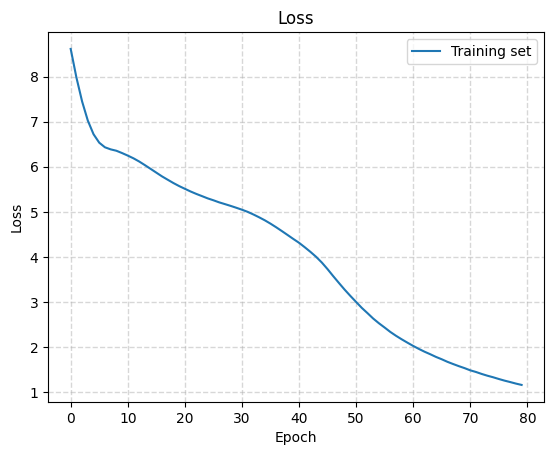

In [7]:
# Train briefly and plot loss
EPOCHS = 80
history = model.fit(x=dataset, epochs=EPOCHS, callbacks=callbacks)

plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='Training set')
plt.legend(); plt.grid(linestyle='--', linewidth=1, alpha=0.5)
plt.show()

# Resource summary/plots
# monitor_cb.monitor.plot_all()
# monitor_cb.monitor.get_summary_stats()


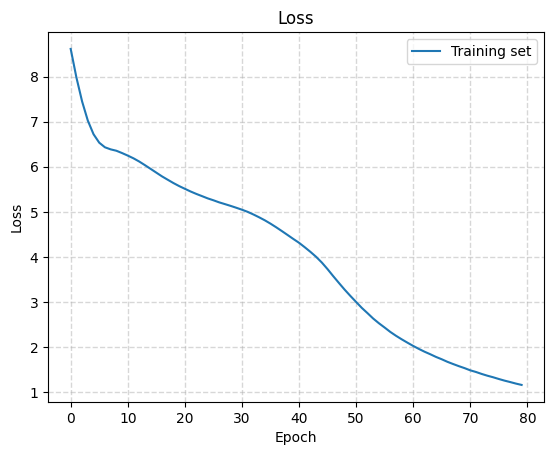

In [8]:
# Render training history (same style as GRU)
def render_training_history(training_history):
    loss = training_history.history.get('loss', [])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

render_training_history(history)


In [9]:
# Reload best weights and add generation helper
import glob
weight_files = glob.glob(os.path.join(checkpoint_dir, '*.weights.h5'))
if weight_files:
    latest = max(weight_files, key=os.path.getctime)
    model.load_weights(latest)
    print(f"Loaded weights from: {latest}")
else:
    print("No weights file found. Using randomly initialized model.")


def generate_text(model, start_string, num_generate=1000, temperature=1.0):
    input_ids = custom_tokenizer.encode(start_string)
    input_ids = tf.expand_dims(input_ids, 0)
    generated_tokens = []
    for _ in range(num_generate):
        logits = model(input_ids)
        logits = logits[:, -1, :] / temperature
        predicted_id = tf.random.categorical(logits, num_samples=1)[:, -1].numpy()[0]
        generated_tokens.append(predicted_id)
        input_ids = tf.concat([input_ids, tf.expand_dims([[predicted_id]], 0)[:, 0, :]], axis=1)
    return start_string + custom_tokenizer.decode(generated_tokens)

print(generate_text(model, start_string="Sherlock Holmes looked at the ", num_generate=300, temperature=1.0))
print(generate_text(model, start_string="My dear Watson ", num_generate=500))
print(generate_text(model, start_string=u"Sherlock: "))

Loaded weights from: ./tmp-transformer/checkpoints/model_epoch_80.weights.h5


Sherlock Holmes looked at the ls supper story woman Was living whose eyes minutes saysbuilding plain danger who looked glasses companion trusty picked walked having having having having having having having such such much just just deduce kindly salesman yesterday anger machine gems attention next marriage marriage bankhead bloodstrange paper men broad bright American story dress dearit red two other other other other other other other man other frontthat
























s a old his
 third there two—kitchen
bright old men his
 John
either
it one— His
s
 fell
One to every &Ser metal.” His— Wil—per——.’
attentions quarter ladys Adler lashed“‘sided thin bridge— each throwing# the greater those A every Vincent old newourll— Grnightoffices rattling life visitors.”
ast.” old— was
 public.”
 other.”

 peeped question— down.” his.” pure vile face people who—undateslee his came
s
 abs Thats shiny?” Miss w.”Pondicherryen.”S practicalgr meant dears—.”
“A intimate was with.”
How
This.”
 bre

My dear Watson  mood interview hours pocket brilliant cigar pink delicacy passing master smiling laughing yes she she leaning people rooms rooms As but butdread rugolplace cloud reasoninginess boxtercle bearing painsdetails room dress dress quietly examination Whitney leaveslesines floor room night night OF cry name way cab crop cord quarrel full along instinct City horse maker Thursday Whitneymentonily closed sunk proceedings windows new excellent day hair lady lady person bachelor sticksrec buttonpectvering losthappy refuse love said said said press mind mind squ growing, “flesility contincture Mary bornelightswouldep co sunthree golden pledgeetyides emotserve whetherraw L trivialeverythingfar floor oldsearchield drawer perhaps coronet expressionconviction advice away crowd soul manager convinced dress worse papers woman attached kne reported morning why landlord deepest gettingoubt! reasonerichturnediourvanished cheeks daughter waxas conclusion tinevencountryomethingscream saferager

Sherlock:  dffe supp owner sister sister sister Roylott Rucastle heart heart use lock well well companion family own own own own own own own own own own own own own own son sonHolmes remarked case Swan evening noble convincing arrive perhaps perhaps yetarranging answer clear afraid typewritten now now whatever sir sir evening evening evening thingsreasoning here here here here what what what whatprit sortlowlyever Spaulding Arthur us someone many many prison water neither finally being half half longmorning carriage gambler altar thumb sitting cVregardmur boxes anda hun, George knchamber larger definite watchedMcCarthyyearsexcellentshutbut grey bascan meaningror though tones notes passage walls whose woman
fields carriage carriage circle examined inside hour inhabited passage heavensushes woman_.appointed of,deductionapproachedfurther fiverposal tupind‘Which: tryingdwriting side though babytook handsome situationpull yet metallicforevercentwith following there cheeksFireken hotel preli

In [10]:
import language_tool_python
def evaluate_grammar_quality(generated_text):

    try:
        tool = language_tool_python.LanguageTool('en-GB')
    except:
        print("LanguageTool not available. Installing via pip...")
        import subprocess
        import sys
        subprocess.check_call([sys.executable, "-m", "pip", "install", "language-tool-python"])
        tool = language_tool_python.LanguageTool('en-GB')
    
    # Find grammar and spelling errors
    matches = tool.check(generated_text)
    
    # Count errors by category
    error_categories = Counter()
    for match in matches:
        error_categories[match.category] = error_categories.get(match.category, 0) + 1
    
    # Calculate word count
    words = re.findall(r'\b\w+\b', generated_text)
    word_count = len(words)
    
    # Calculate errors per 100 words
    errors_per_100_words = (len(matches) / max(1, word_count)) * 100
    
    results = {
        'total_errors': len(matches),
        'error_categories': dict(error_categories),
        'errors_per_100_words': errors_per_100_words,
        'word_count': word_count
    }
    
    return results

def merge_error_categories(error_cat_list):
    merged = Counter()
    for error_cat in error_cat_list:
        for category, count in error_cat.items():
            merged[category] += count
    
    # Calculate averages
    result = {category: count / len(error_cat_list) for category, count in merged.items()}
    return result


def run_evaluations(model, start_string, num_runs=5, num_tokens=300, temperatures=[0.7, 1.0]):
    all_results = {}
    
    for temp in temperatures:
        print(f"\nEvaluating temperature: {temp}")
        run_results = []
        
        for run in range(1, num_runs + 1):
            print(f"  Run {run}/{num_runs}...")
            text = generate_text(model, start_string, num_tokens, temp)
            run_results.append(evaluate_grammar_quality(text))
        
        # Calculate averages across runs
        avg_results = {
            'total_errors': sum(r['total_errors'] for r in run_results) / num_runs,
            'errors_per_100_words': sum(r['errors_per_100_words'] for r in run_results) / num_runs,
            'word_count': sum(r['word_count'] for r in run_results) / num_runs,
            'error_categories': merge_error_categories([r['error_categories'] for r in run_results])
        }
        
        # Store individual runs for reference
        avg_results['individual_runs'] = run_results
        all_results[temp] = avg_results
    
    return all_results


In [11]:
temperatures = [1.0]  # or [0.2, 0.5, 0.7, 1.0, 1.3, 1.7, 2.0] to mirror full sweep
start_string = "Sherlock Holmes looked at the"

In [12]:
results = run_evaluations(
    model,
    start_string=start_string,
    num_runs=5,
    num_tokens=300,
    temperatures=temperatures
)


Evaluating temperature: 1.0
  Run 1/5...


  Run 2/5...


  Run 3/5...


  Run 4/5...


  Run 5/5...


In [13]:
print("\n===== AVERAGED RESULTS =====")
for temp, result in results.items():
    print(f"\nTemperature: {temp}")
    print(f"Average total errors: {result['total_errors']:.2f}")
    print(f"Average errors per 100 words: {result['errors_per_100_words']:.2f}")
    print(f"Average word count: {result['word_count']:.2f}")
    print("Average error categories:")
    for category, avg_count in sorted(result['error_categories'].items(), key=lambda x: x[1], reverse=True):
        print(f"  - {category}: {avg_count:.2f}")


===== AVERAGED RESULTS =====

Temperature: 1.0
Average total errors: 51.80
Average errors per 100 words: 20.50
Average word count: 256.20
Average error categories:
  - TYPOS: 28.40
  - MISC: 9.20
  - GRAMMAR: 8.00
  - PUNCTUATION: 4.60
  - TYPOGRAPHY: 0.80
  - CASING: 0.60
  - CONFUSED_WORDS: 0.20
